![Logo_Conestoga](https://upload.wikimedia.org/wikipedia/commons/3/34/Conestoga_College_logo.png)

Foundations of Machine Learning Frameworks
&nbsp; 

CSCN8010 - Winter 2024
&nbsp; 

**Professor:** Ran Feldesh
&nbsp;

**Group Name:** Final Project 15 <br>


**Group members:** <br>
Joseph, Sachin <br>
Fernandez, Arcadio <br>


# Assignment 2 - Final Project: **Alzheimer Prediction with MR Images** 

#  1. A brief introduction to the problem

1.	Clear Problem Statement (Objective, Motivation, Method) <br>
According to the World Health Organization, in March 2023, there are more than 55 million people who have dementia worldwide. Dementia results from a variety of diseases and injuries that affect the brain. Alzheimer's disease is the most common form of dementia and may contribute to 60–70% of cases, so we are talking about 33 to 38.5 million people. 
Our objective is to analyze an Alzheimer's Magnetic Resonance Imaging (MRI) preprocessed Dataset using Machine Learning algorithms to identify a person's dementia stage.


2.	Interesting Choice of Problem <br>
Although no treatment can revert Alzheimer’s disease, Rasmussen et al. (2019) asserted that a diagnosis early in the course of illness allows time for all concerned to adjust while the patient can still actively engage and offers access to advice, financial support and non-pharmacological and pharmacological treatments. 
Because of this our project proposes to deal with this issue of early diagnosis by identifying through the images of patients with Very Mild Demented, Mild Demented, Moderate Demented or Non-Demented.

3.	Reasonable (Doable) Choice of Problem<br>
The key categories of applications of artificial intelligence (AI) in healthcare, according to Davenport et al. (2019), involve diagnosis and treatment recommendations, patient engagement and adherence, and administrative activities. So, by choosing the Alzheimer's MRI project, we correspond to the necessity of the healthcare industry to use AI to diagnose and make treatment recommendations.

4.	Review of the Data Source <br>
After going through many datasets on Kaggle, we discovered the Alzheimer MRI Preprocessed Dataset, with a usability of 8.75 and 11,044 downloads (06/04/23). The Dataset contains 6400 MRI images collected from several sources. All the images are resized into 128 x 128 pixels; the Dataset has four classes of images.<br>
https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data


* Total 6400 images belongs to 4 different classes:

    - Mild Demented
    - Moderate Demented
    - Non Demented
    - Very Mild Demented



5.	Indication of Reference Code<br>
On Kaggle at Alzheimer MRI Preprocessed Dataset, there are 70 codes and two caught our attention because of its organization, the use of CNN and the way the result is exposed:<br>
https://www.kaggle.com/code/ahmetesencan/alzheimer-mri-classification-using-cnn <br>
https://www.kaggle.com/code/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading




# 2. Importing required packages

. Importing required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 3. Exploratory data analysis - EDA

## 3.1. Dataset Distribution

There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.


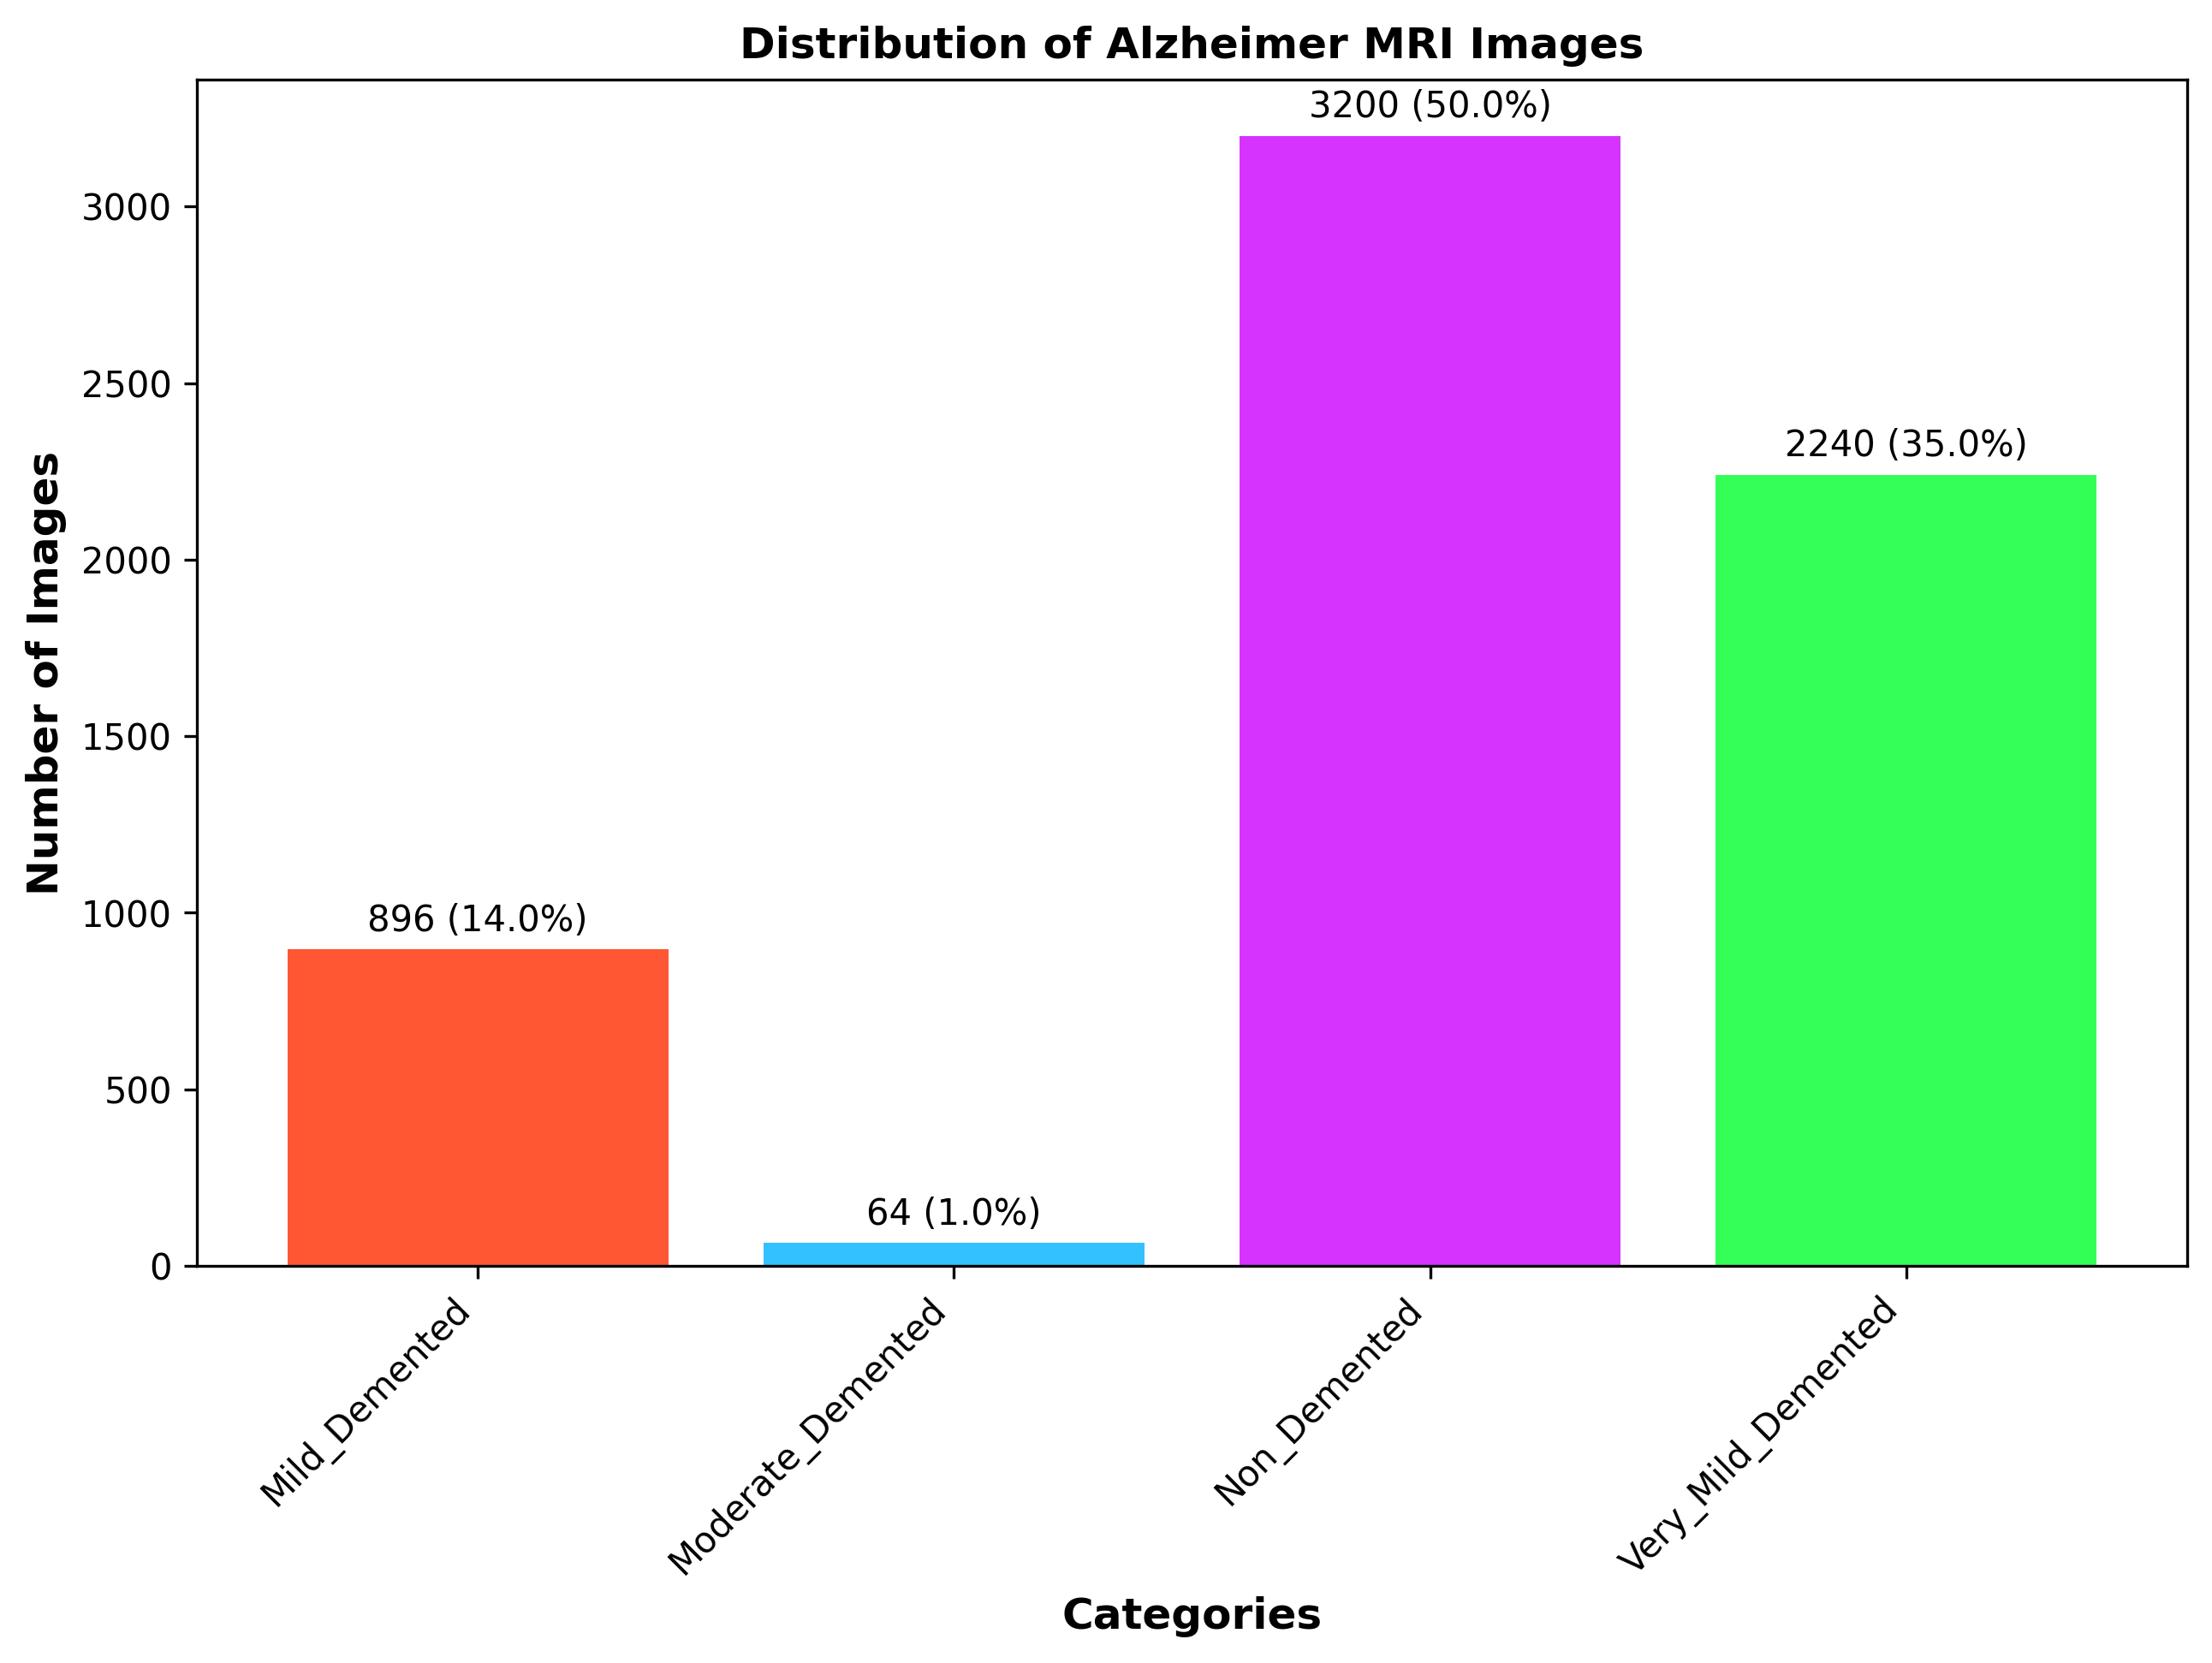

In [2]:
import os
import matplotlib.pyplot as plt

class_dist = {}
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#FF5733", "#33C1FF", "#D633FF", "#33FF57"]  


def image_counter(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png']
    # Traverse the directory and count images
    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0
            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()
                if file_ext in image_extensions:
                    count += 1
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    total_images = sum(values)

    # Create a bar chart
    fig, ax = plt.subplots()
    bars = ax.bar(keys, values, color=colors[:len(keys)])
    ax.set_xlabel('Categories', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Alzheimer MRI Images', fontsize=12, fontweight='bold')
    ax.set_xticklabels(keys, rotation=45, ha="right", fontsize=10)

    # Add data labels to each bar
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_images) * 100
        ax.annotate(f'{height} ({percentage:.1f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.show()

PATH = 'Dataset'
image_counter(PATH)


* Moderate Demented class has very less images when comapred with others, this indicates a imbalance in the dataset.
* Class imbalance is managed by giving higher weights to the minority class. Class weight os inversly proportionaly to the frequencies.
* weight = (total number of samples)/ (number of classes×number of samples in class i)

## 3.2. Size of all images

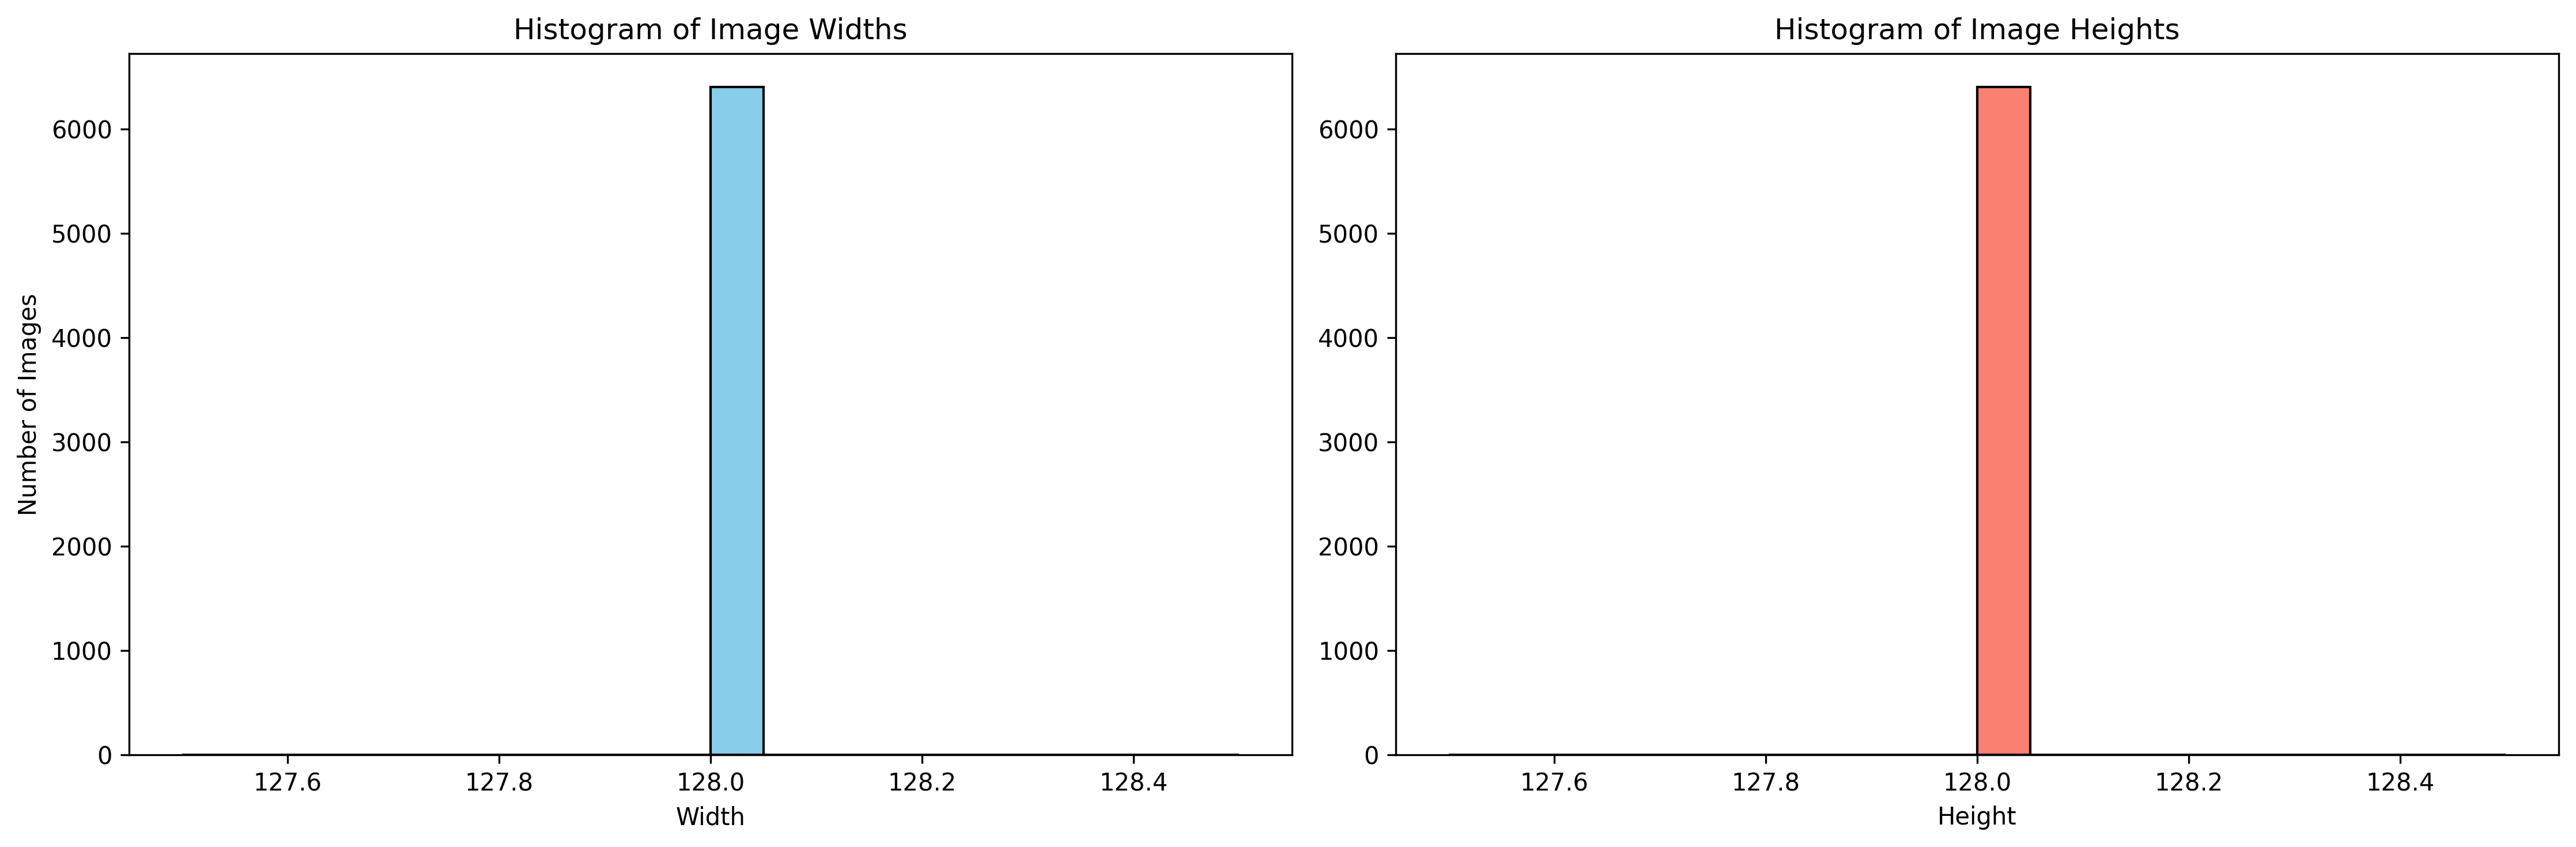

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def image_size_histogram(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png']
    widths = []
    heights = []
    
    # Traverse the directory and gather image dimensions
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_ext = os.path.splitext(file)[1].lower()
            if file_ext in image_extensions:
                image_path = os.path.join(root, file)
                img = mpimg.imread(image_path)
                h, w = img.shape[:2]  # Extract the height and width
                widths.append(w)
                heights.append(h)

    # Plotting histograms
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram for widths
    axs[0].hist(widths, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_title('Histogram of Image Widths')
    axs[0].set_xlabel('Width')
    axs[0].set_ylabel('Number of Images')
    
    # Histogram for heights
    axs[1].hist(heights, bins=20, color='salmon', edgecolor='black')
    axs[1].set_title('Histogram of Image Heights')
    axs[1].set_xlabel('Height')
    
    plt.tight_layout()
    plt.show()

# Call the function with the path to your dataset
PATH = 'Dataset'
image_size_histogram(PATH)


Widths and heights of the images are clustered around a single value 128 x 128 pixels. This suggests that the dataset consists of images that have been standardized to this specific size.

## 3.3. Identify the Color Scheme

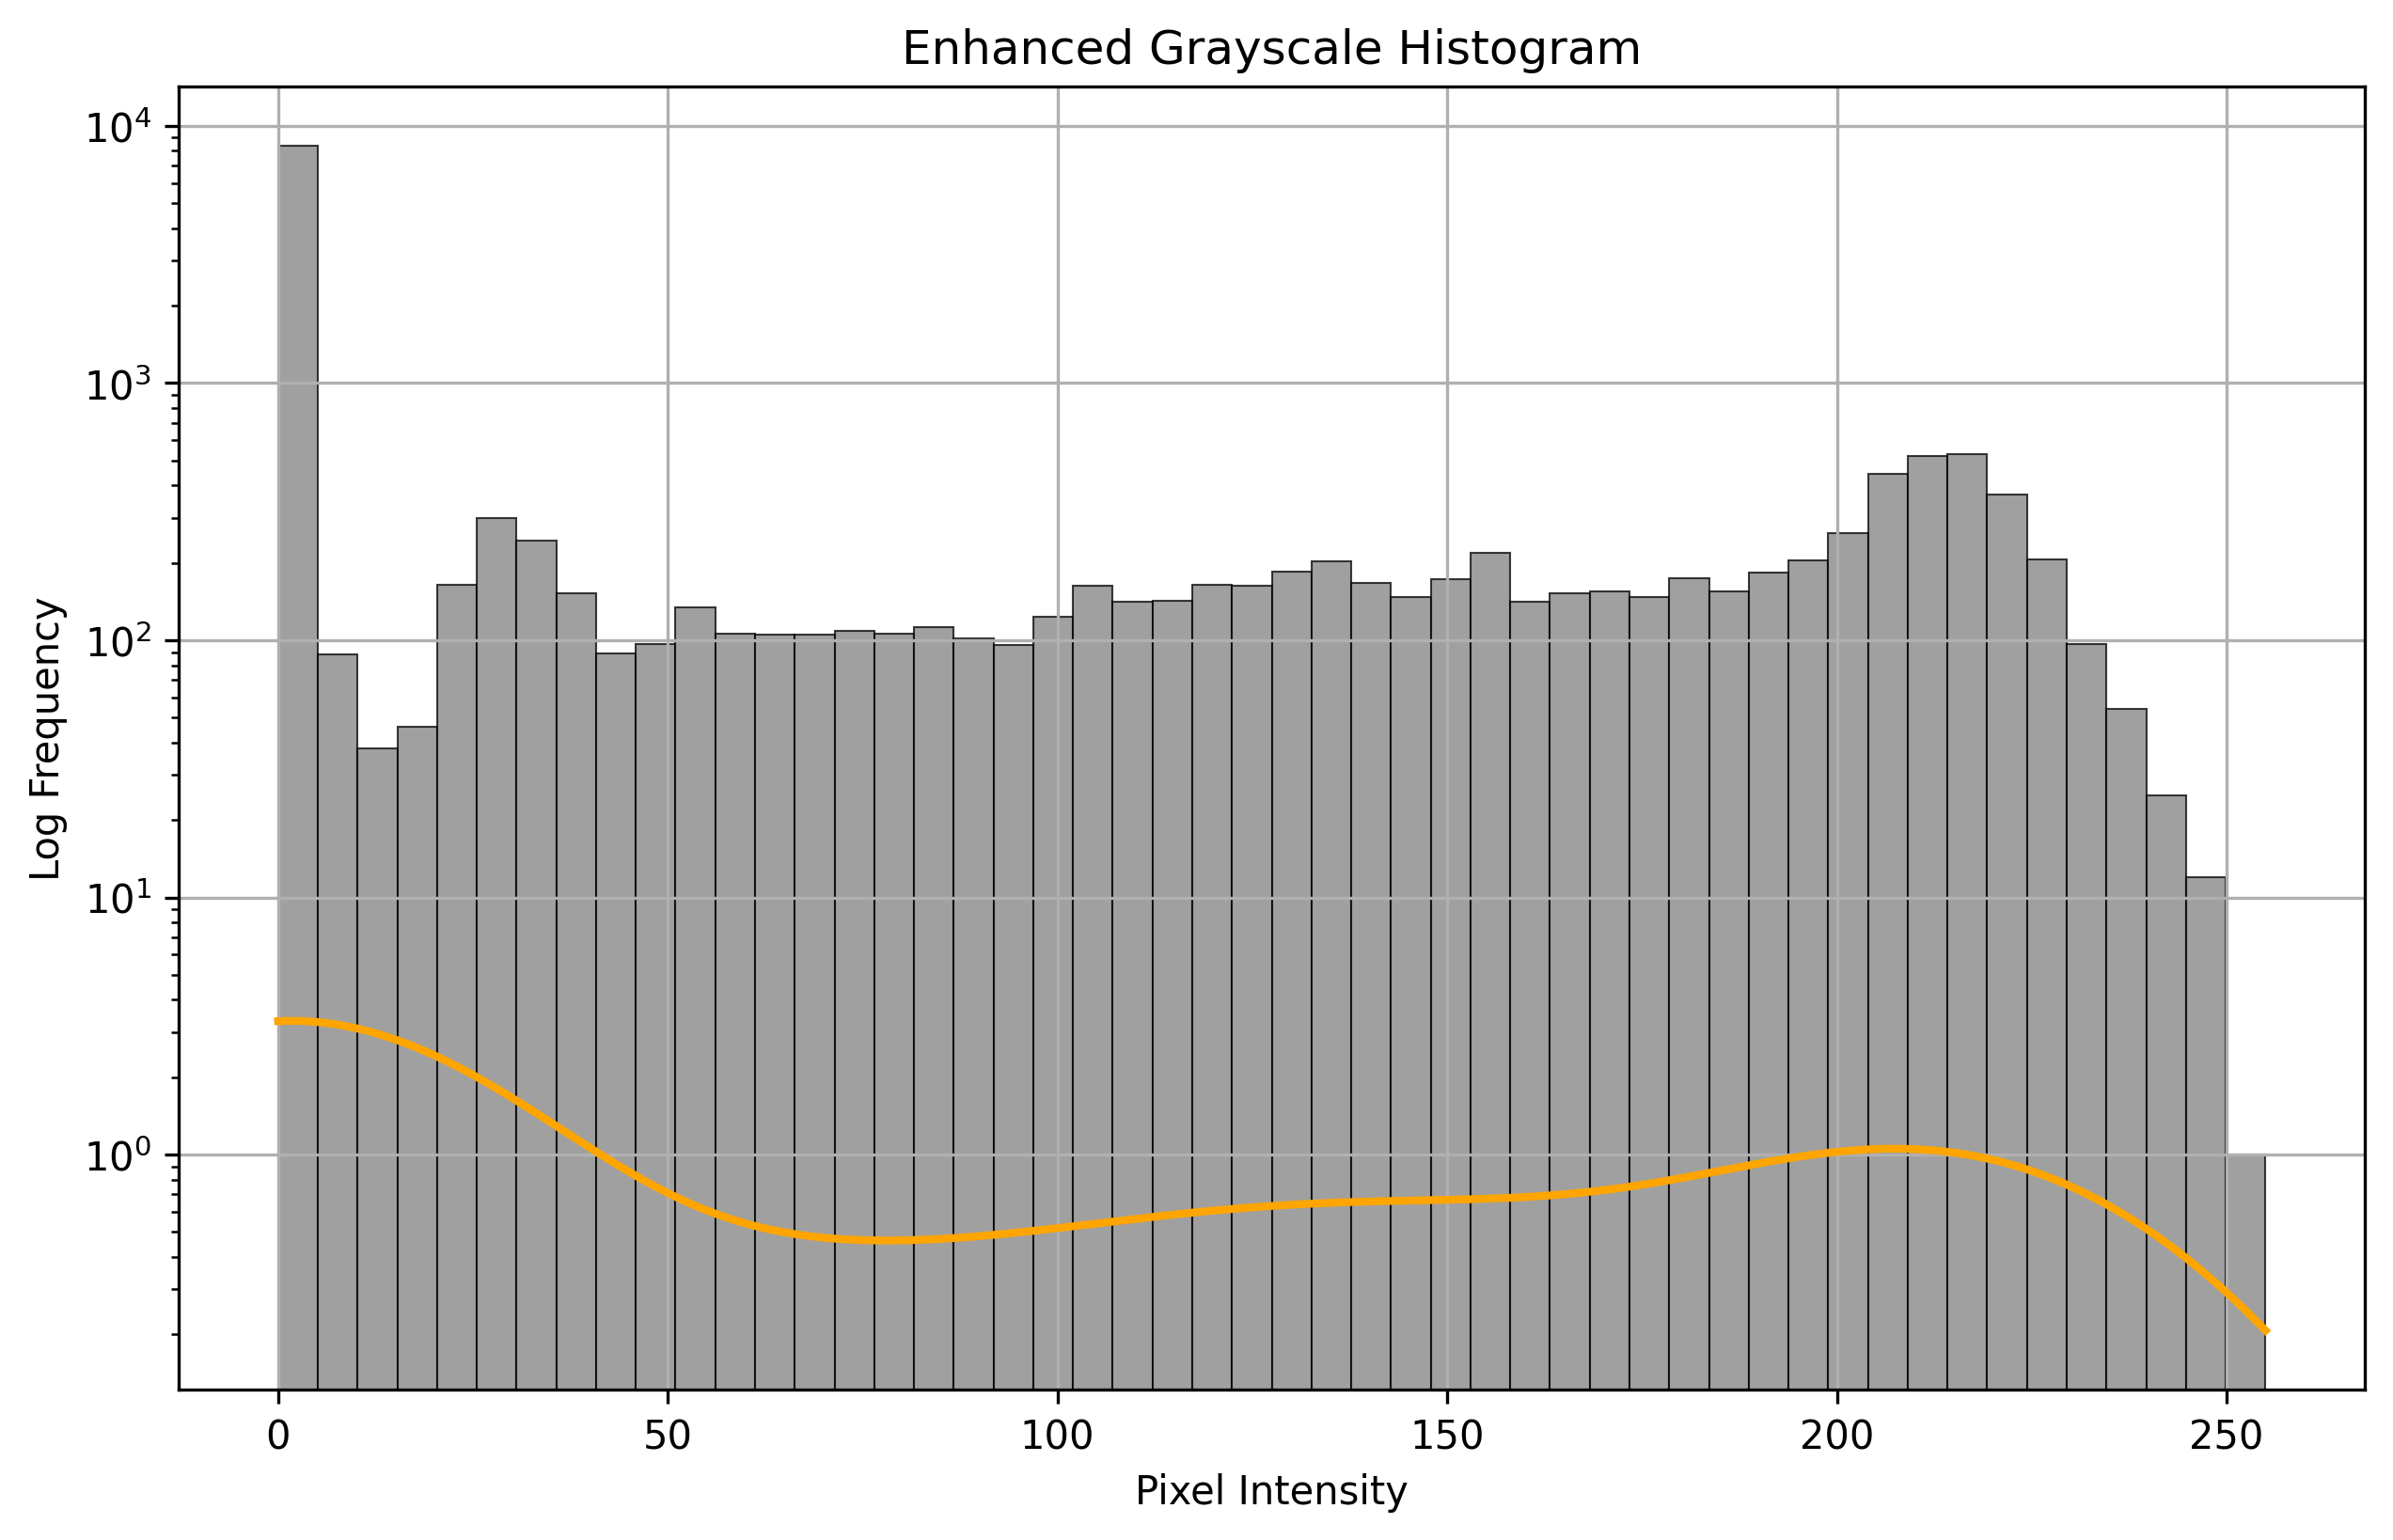

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.stats import gaussian_kde

def enhanced_grayscale_histogram(image_path):
    # Load the image
    img = mpimg.imread(image_path)
    # If the image has more than one channel, take only one channel
    if len(img.shape) == 3:
        img = img[:, :, 0]
    # Flatten the image to 1D array
    pixels = img.flatten()
    
    # Calculate the point density
    density = gaussian_kde(pixels, bw_method=0.5)
    xs = np.linspace(0, 255, 256)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    
    # Create the histogram with a logarithmic scale
    plt.figure(figsize=(10, 6))
    plt.hist(pixels, bins=50, range=(0, 255), color='gray', alpha=0.75, log=True, edgecolor='black', linewidth=0.5)
    
    # Add the density curve
    plt.plot(xs, density(xs)*len(pixels)/50, color='orange', lw=2)
    
    plt.title('Enhanced Grayscale Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Log Frequency')
    plt.grid(True)
    plt.show()

# Assuming the 'Dataset' directory is correctly set and contains image files
dataset_path = 'Dataset'  # The path to your dataset directory

def get_first_image_path(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                return os.path.join(root, file)
    return None

# Get the first image path from the dataset directory
first_image_path = get_first_image_path(dataset_path)

# Check if the image file exists and is a file
if first_image_path and os.path.isfile(first_image_path):
    enhanced_grayscale_histogram(first_image_path)
else:
    print(f"No image files found in the directory {dataset_path}.")


The histogram bars represent the count of pixels at each intensity level on a log scale, and the orange line is the Kernel Density Estimate (KDE) that provides a smooth curve of the distribution.

The pixel intensities are spread across the entire range, from black (0) to white (255), with a relatively uniform distribution in the GrayScale.

This type of histogram is helpful to understand the contrast and brightness of an image. In terms of image processing, if you find that the image is too dark or too bright, you might apply contrast adjustment techniques like histogram equalization.

## 3.4. Analysing images from the 4 classes:

### 3.4.1. Creating a Tensorflow Dataset to scroll through the images from the 4 classes (and for further reports)

In [5]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names
class_names

Found 6400 files belonging to 4 classes.


['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [6]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### 3.4.2. Samples for each class

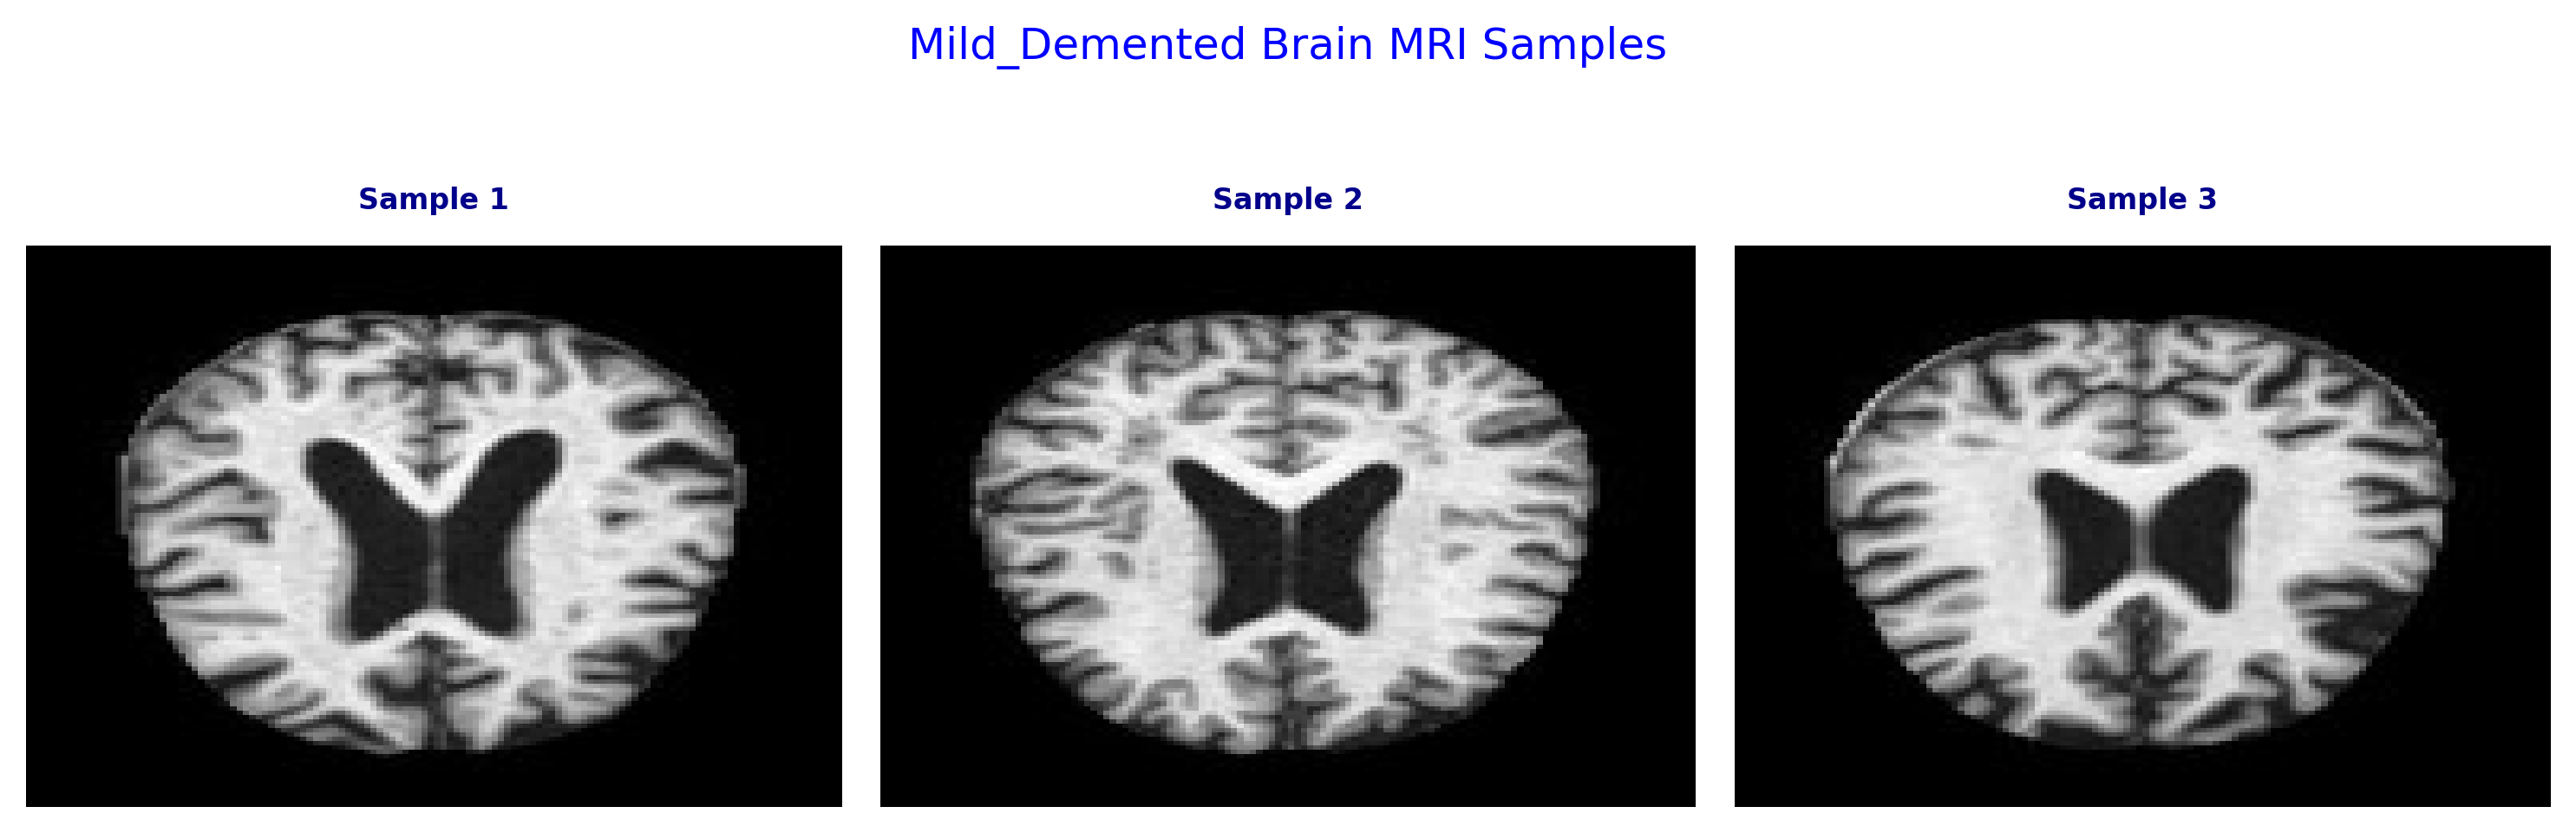

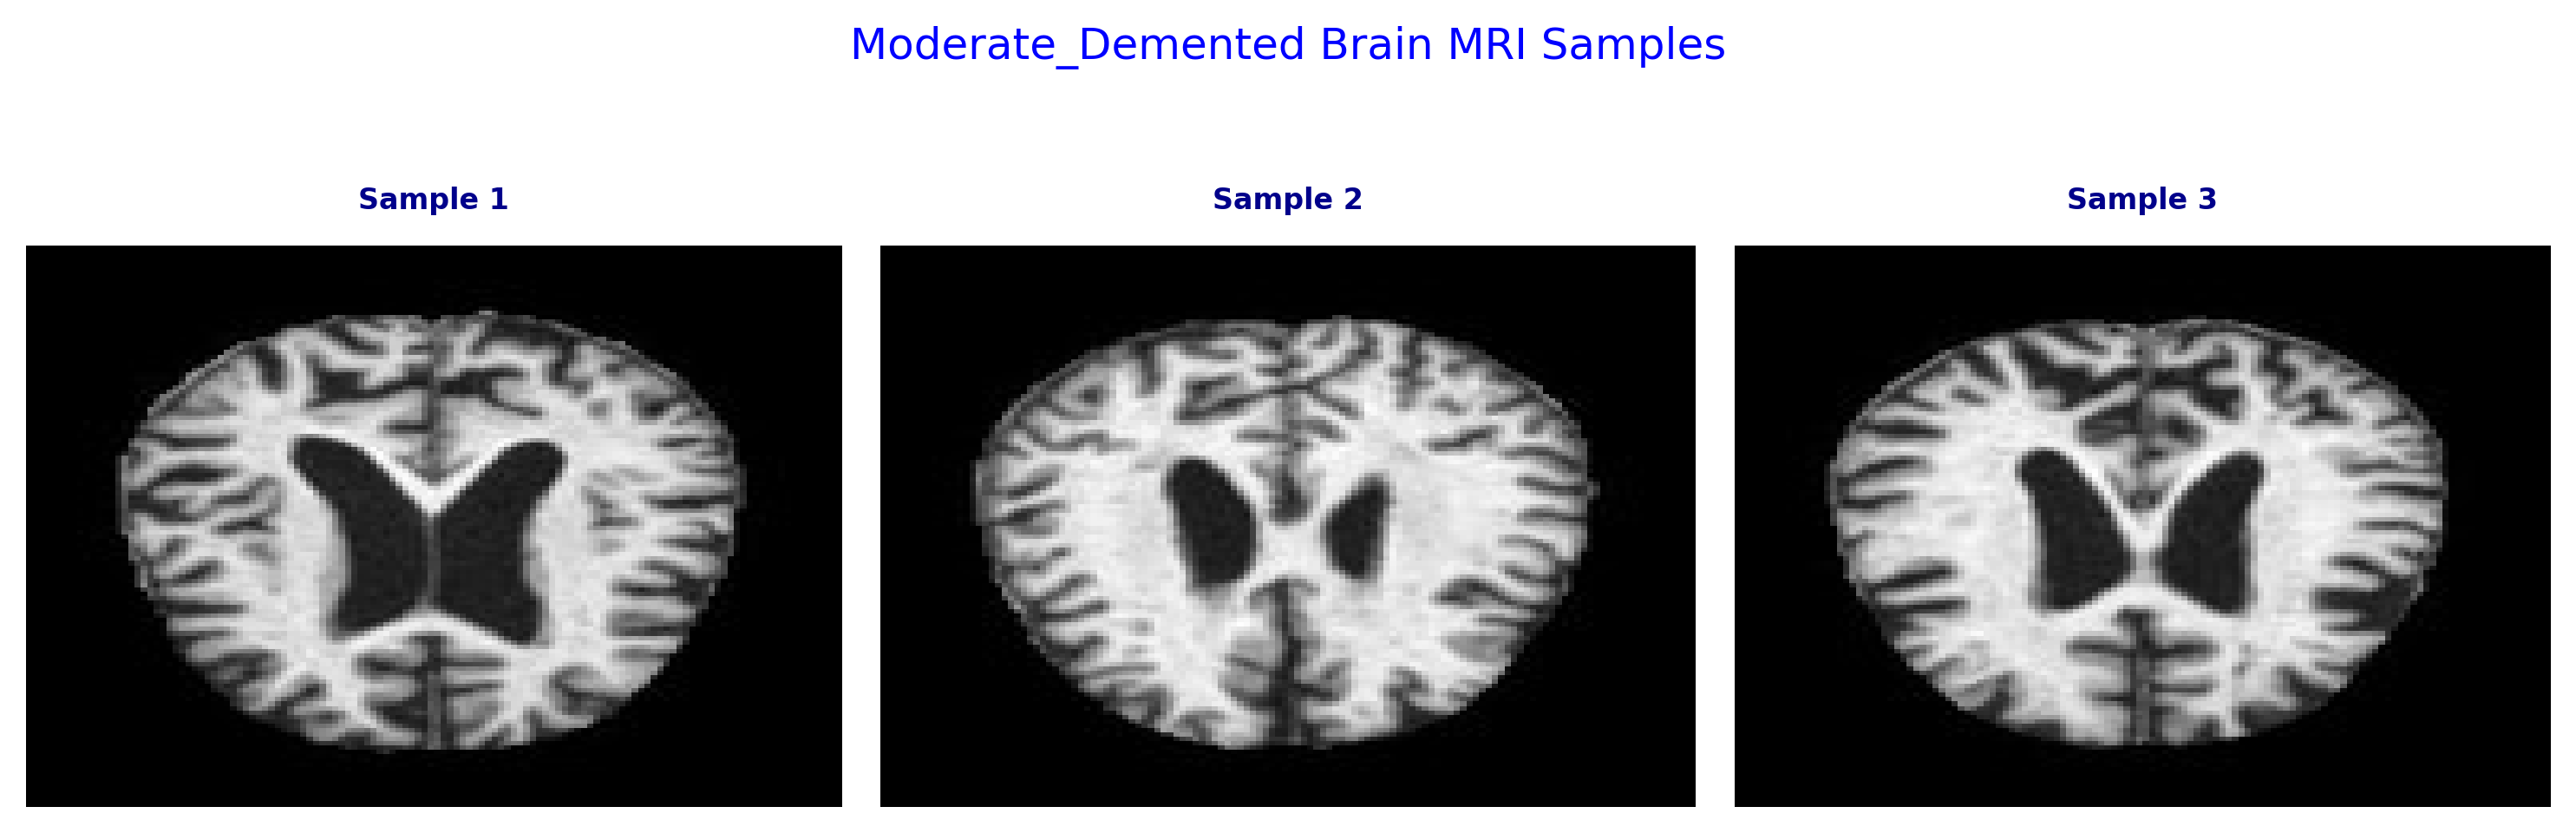

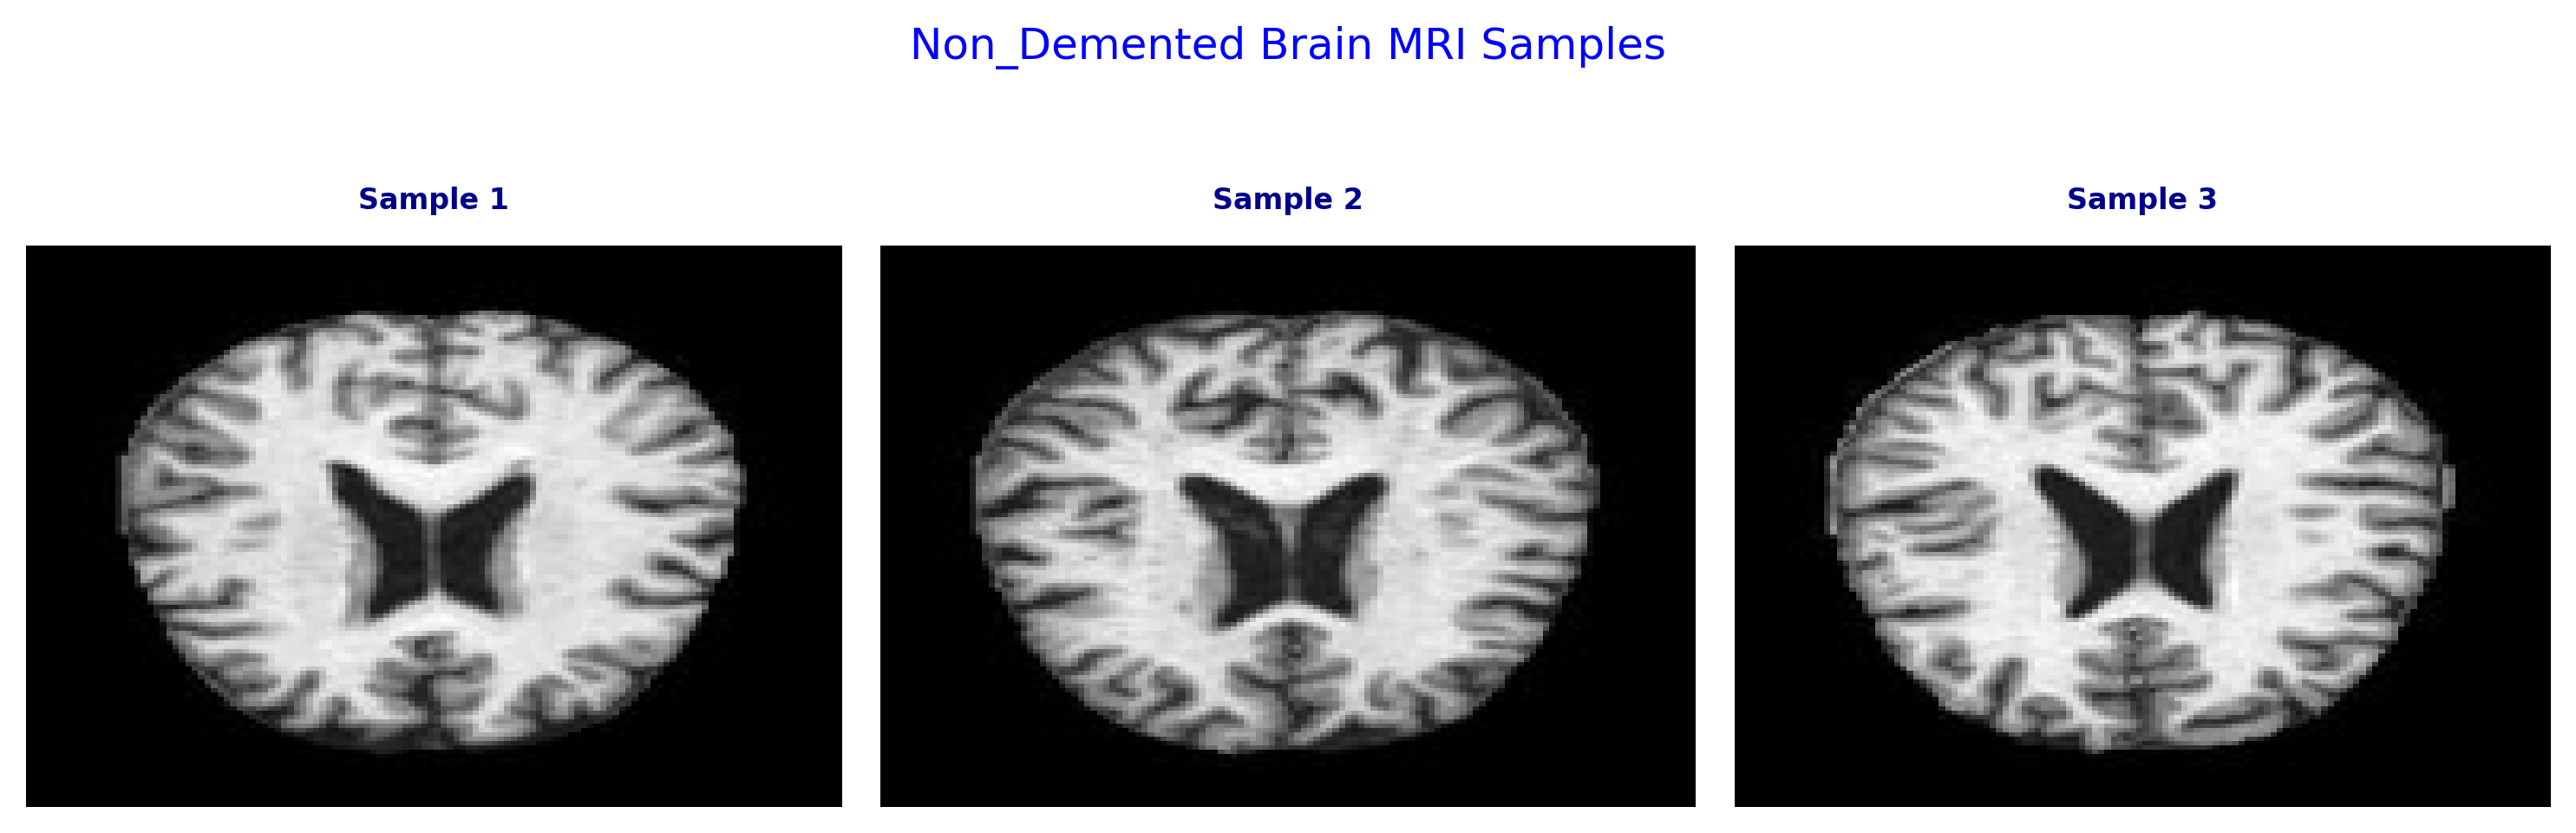

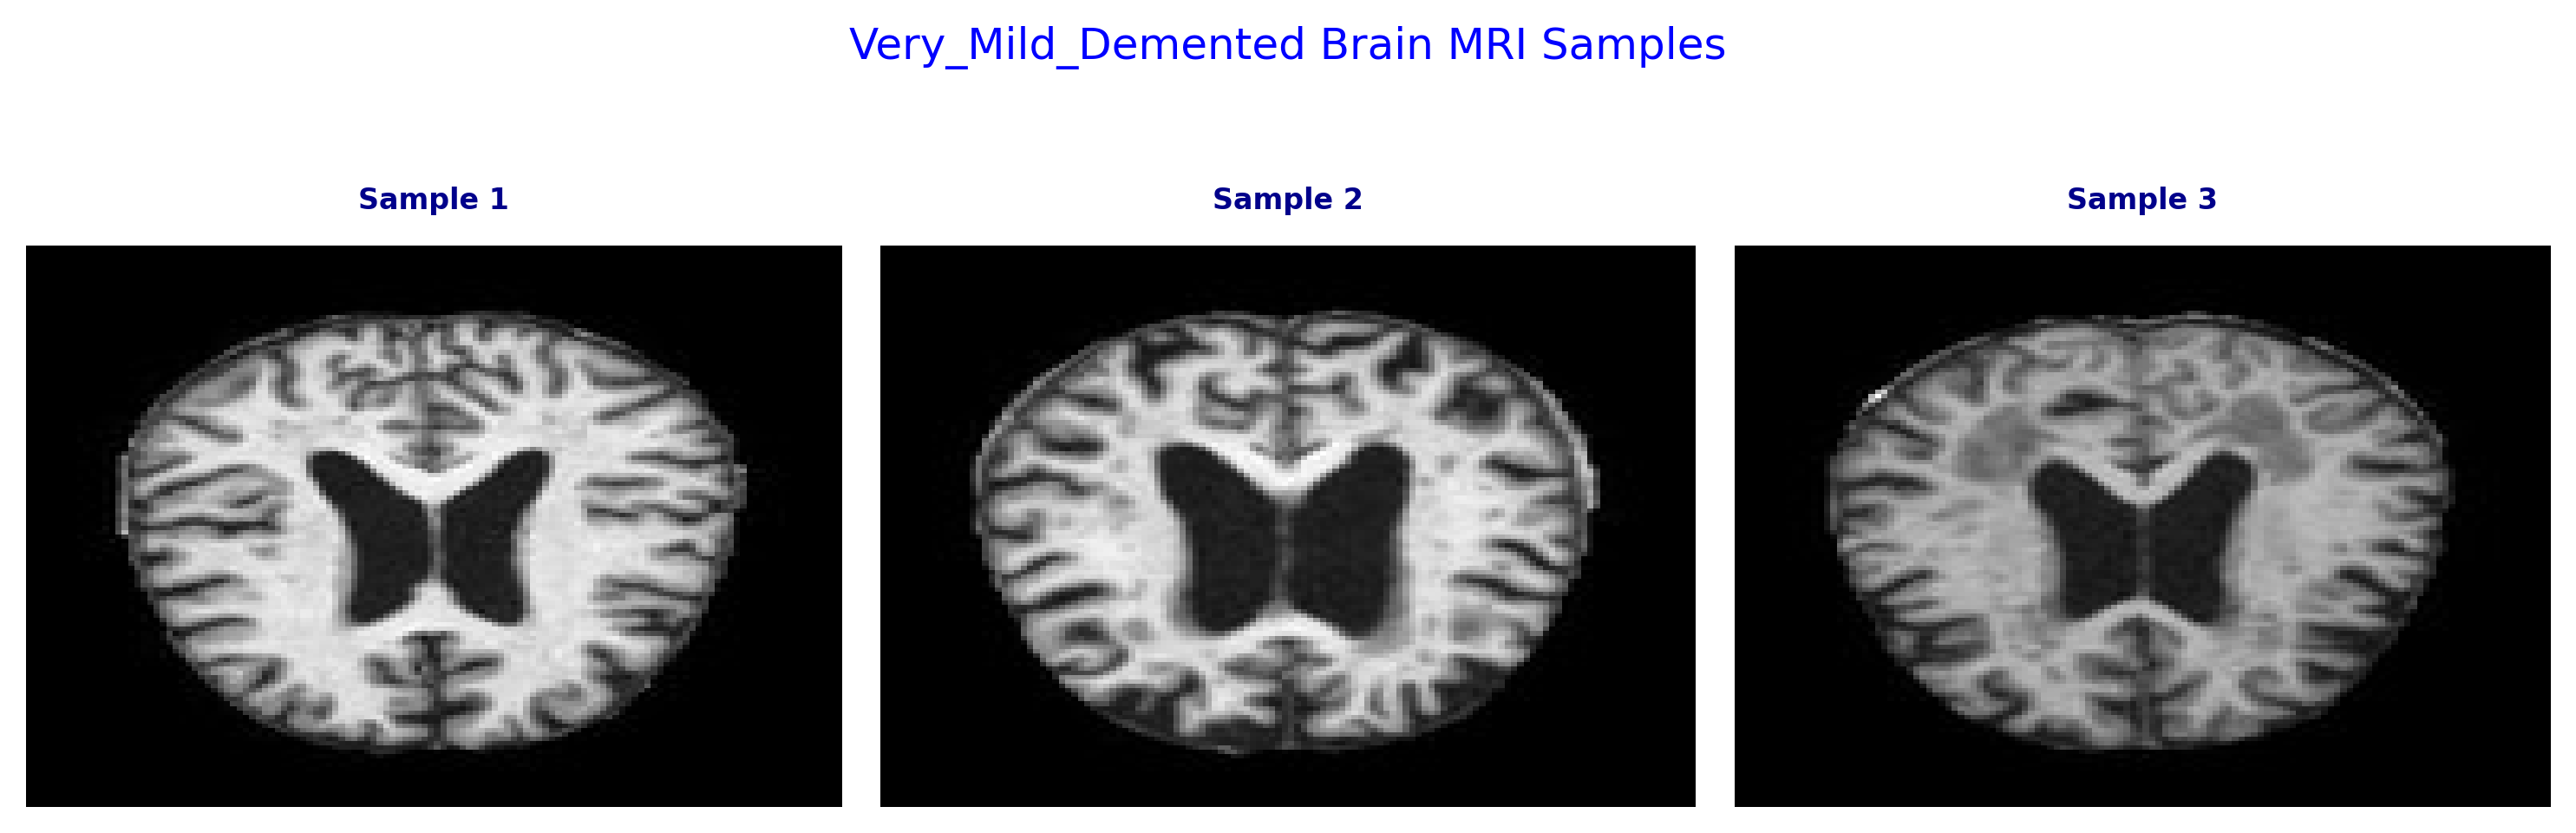

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'class_names' with the actual list of class names you have
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']  # example class names

# Samples of the images
def sample_bringer(path, target, num_samples=3):
    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, figsize=(10,3))  # You can adjust the figsize to better fit your samples
    fig.suptitle(f'{target} Brain MRI Samples', color="blue", fontsize=12, y=1.05)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        # Display image in grayscale
        ax[i].imshow(img, cmap='gray', aspect='auto')
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="darkblue", fontsize=8, fontweight="bold", pad=10)

    plt.tight_layout()
    plt.show()
    
PATH = 'Dataset'  
for target in class_names:
    sample_bringer(PATH, target=target)


# 4. Modeling - Neural Networks 

## 4.1. Dataset Splitting

In [8]:
# Function to split the data into train, test and validation sets
def train_test_val_split(train_size, val_size, test_size):
    train = int(len(data)*train_size)  
    test = int(len(data)*test_size)
    val = int(len(data)*val_size)
    
    train_data = data.take(train)
    val_data = data.skip(train).take(val)
    test_data = data.skip(train+val).take(test)
    return train_data, val_data, test_data

In [9]:
train_data, val_data, test_data= train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)

In [10]:
# Handling the class imbalance
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())  # Compute the class weights, balanced 
class_weights = dict(zip(np.unique(y_train), class_weight))

## 4.2. Model Building

### Model 1:

In [11]:
def build_model():
    model_1 = Sequential()

    model_1.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                   input_shape=(128, 128, 3)))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))
    model_1.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))

    model_1.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model_1.add(MaxPooling2D(pool_size=(2, 2)))

    model_1.add(Flatten())
    model_1.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model_1.add(Dense(64, activation="relu"))
    model_1.add(Dense(4, activation="softmax"))
    model_1.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model_1.summary()

    return model_1

model_1 = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

### Model 2:

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_less_complex_model():
    model_2 = Sequential()

    # First convolutional layer with fewer filters
    model_2.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
                       kernel_initializer='he_normal', input_shape=(128, 128, 3)))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the convolutions
    model_2.add(Flatten())

    # Directly to a final layer with the number of classes
    model_2.add(Dense(4, activation="softmax"))  # Assuming 4 classes

    model_2.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model_2.summary()

    return model_2

# Build the simplified model
model_less_complex = build_less_complex_model()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 63504)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 254020    
                                                                 
Total params: 254,468
Trainable params: 254,468
Non-trainable params: 0
_________________________________________________________________


## *Model 1 Callback*

In [13]:
from tensorflow import keras

checkpoint_filepath_1 = 'best_model_1.keras' 
def callback_model_1():
    callbacks_1 = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath_1,
             save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)  # Saves the entire model, not just weights
    ]
    return callbacks_1

* Early stopping is a form of regularization used to avoid overfitting when training a convolutional neural network (CNN) or any other kind of machine learning model. Overfitting occurs when a model learns the details and noise in the training data to an extent that it negatively impacts the performance of the model on new data

In [14]:
# Early stopping for any case of overfitting
# def early_stopping(patience):
#     es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
#     return es_callback

In [15]:
# checkpoint_callback_1 = callback_model_1()
# # patience refers to the number of epochs to continue training after detecting no improvement
# early_stopping_1 = early_stopping(patience=5)
# check_callbacks_1 = [checkpoint_callback_1, early_stopping_1]

## *Model 2 Callback*

In [16]:
checkpoint_filepath_2 = 'best_model_2.keras' 

def callback_model_2():
    callbacks_2 = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath_2,
            save_best_only=True,
            monitor="val_accuracy",
            mode='min',
            save_weights_only=False)  # Saves the entire model, not just weights
    ]
    return callbacks_2

In [17]:
# checkpoint_callback_2 = callback_model_2()
# early_stopping_2 = early_stopping(patience=5)
# check_callbacks_2 = [checkpoint_callback_2, early_stopping_2]

## *Fit Model 1*

In [18]:
history_1 = model_1.fit(train_data, 
            epochs = 30, 
            validation_data = val_data,
            class_weight = class_weights) 
            # callbacks = check_callbacks_1)

# Extract the history into a pandas DataFrame
history_1_df = pd.DataFrame(history_1.history)

# Add the epoch number
history_1_df['Epoch'] = history_1_df.index + 1

# Reorder the DataFrame such that 'Epoch' is the first column
history_1_df = history_1_df[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

# Print the DataFrame to see the table
print(history_1_df)

Epoch 1/30
 20/160 [==>...........................] - ETA: 19s - loss: 631.2192 - accuracy: 0.2953

160/160 [==============================] - 25s 146ms/step - loss: 82.1903 - accuracy: 0.3553 - val_loss: 1.1971 - val_accuracy: 0.5063
Epoch 2/30
160/160 [==============================] - 24s 147ms/step - loss: 0.8425 - accuracy: 0.5545 - val_loss: 0.7577 - val_accuracy: 0.6687
Epoch 3/30
160/160 [==============================] - 23s 145ms/step - loss: 0.5541 - accuracy: 0.6771 - val_loss: 0.6790 - val_accuracy: 0.7063
Epoch 4/30
160/160 [==============================] - 23s 144ms/step - loss: 0.3684 - accuracy: 0.7803 - val_loss: 0.5122 - val_accuracy: 0.7922
Epoch 5/30
160/160 [==============================] - 24s 147ms/step - loss: 0.2789 - accuracy: 0.8289 - val_loss: 0.5059 - val_accuracy: 0.7953
Epoch 6/30
160/160 [==============================] - 24s 147ms/step - loss: 0.3197 - accuracy: 0.8205 - val_loss: 0.5404 - val_accuracy: 0.7922
Epoch 7/30
160/160 [==============================] - 25s 158ms/step - loss: 0.1969 - accuracy: 0.8838 - val_loss: 0.7398 - val_accuracy: 0.

## *Loss & Accuracy : Model 1*

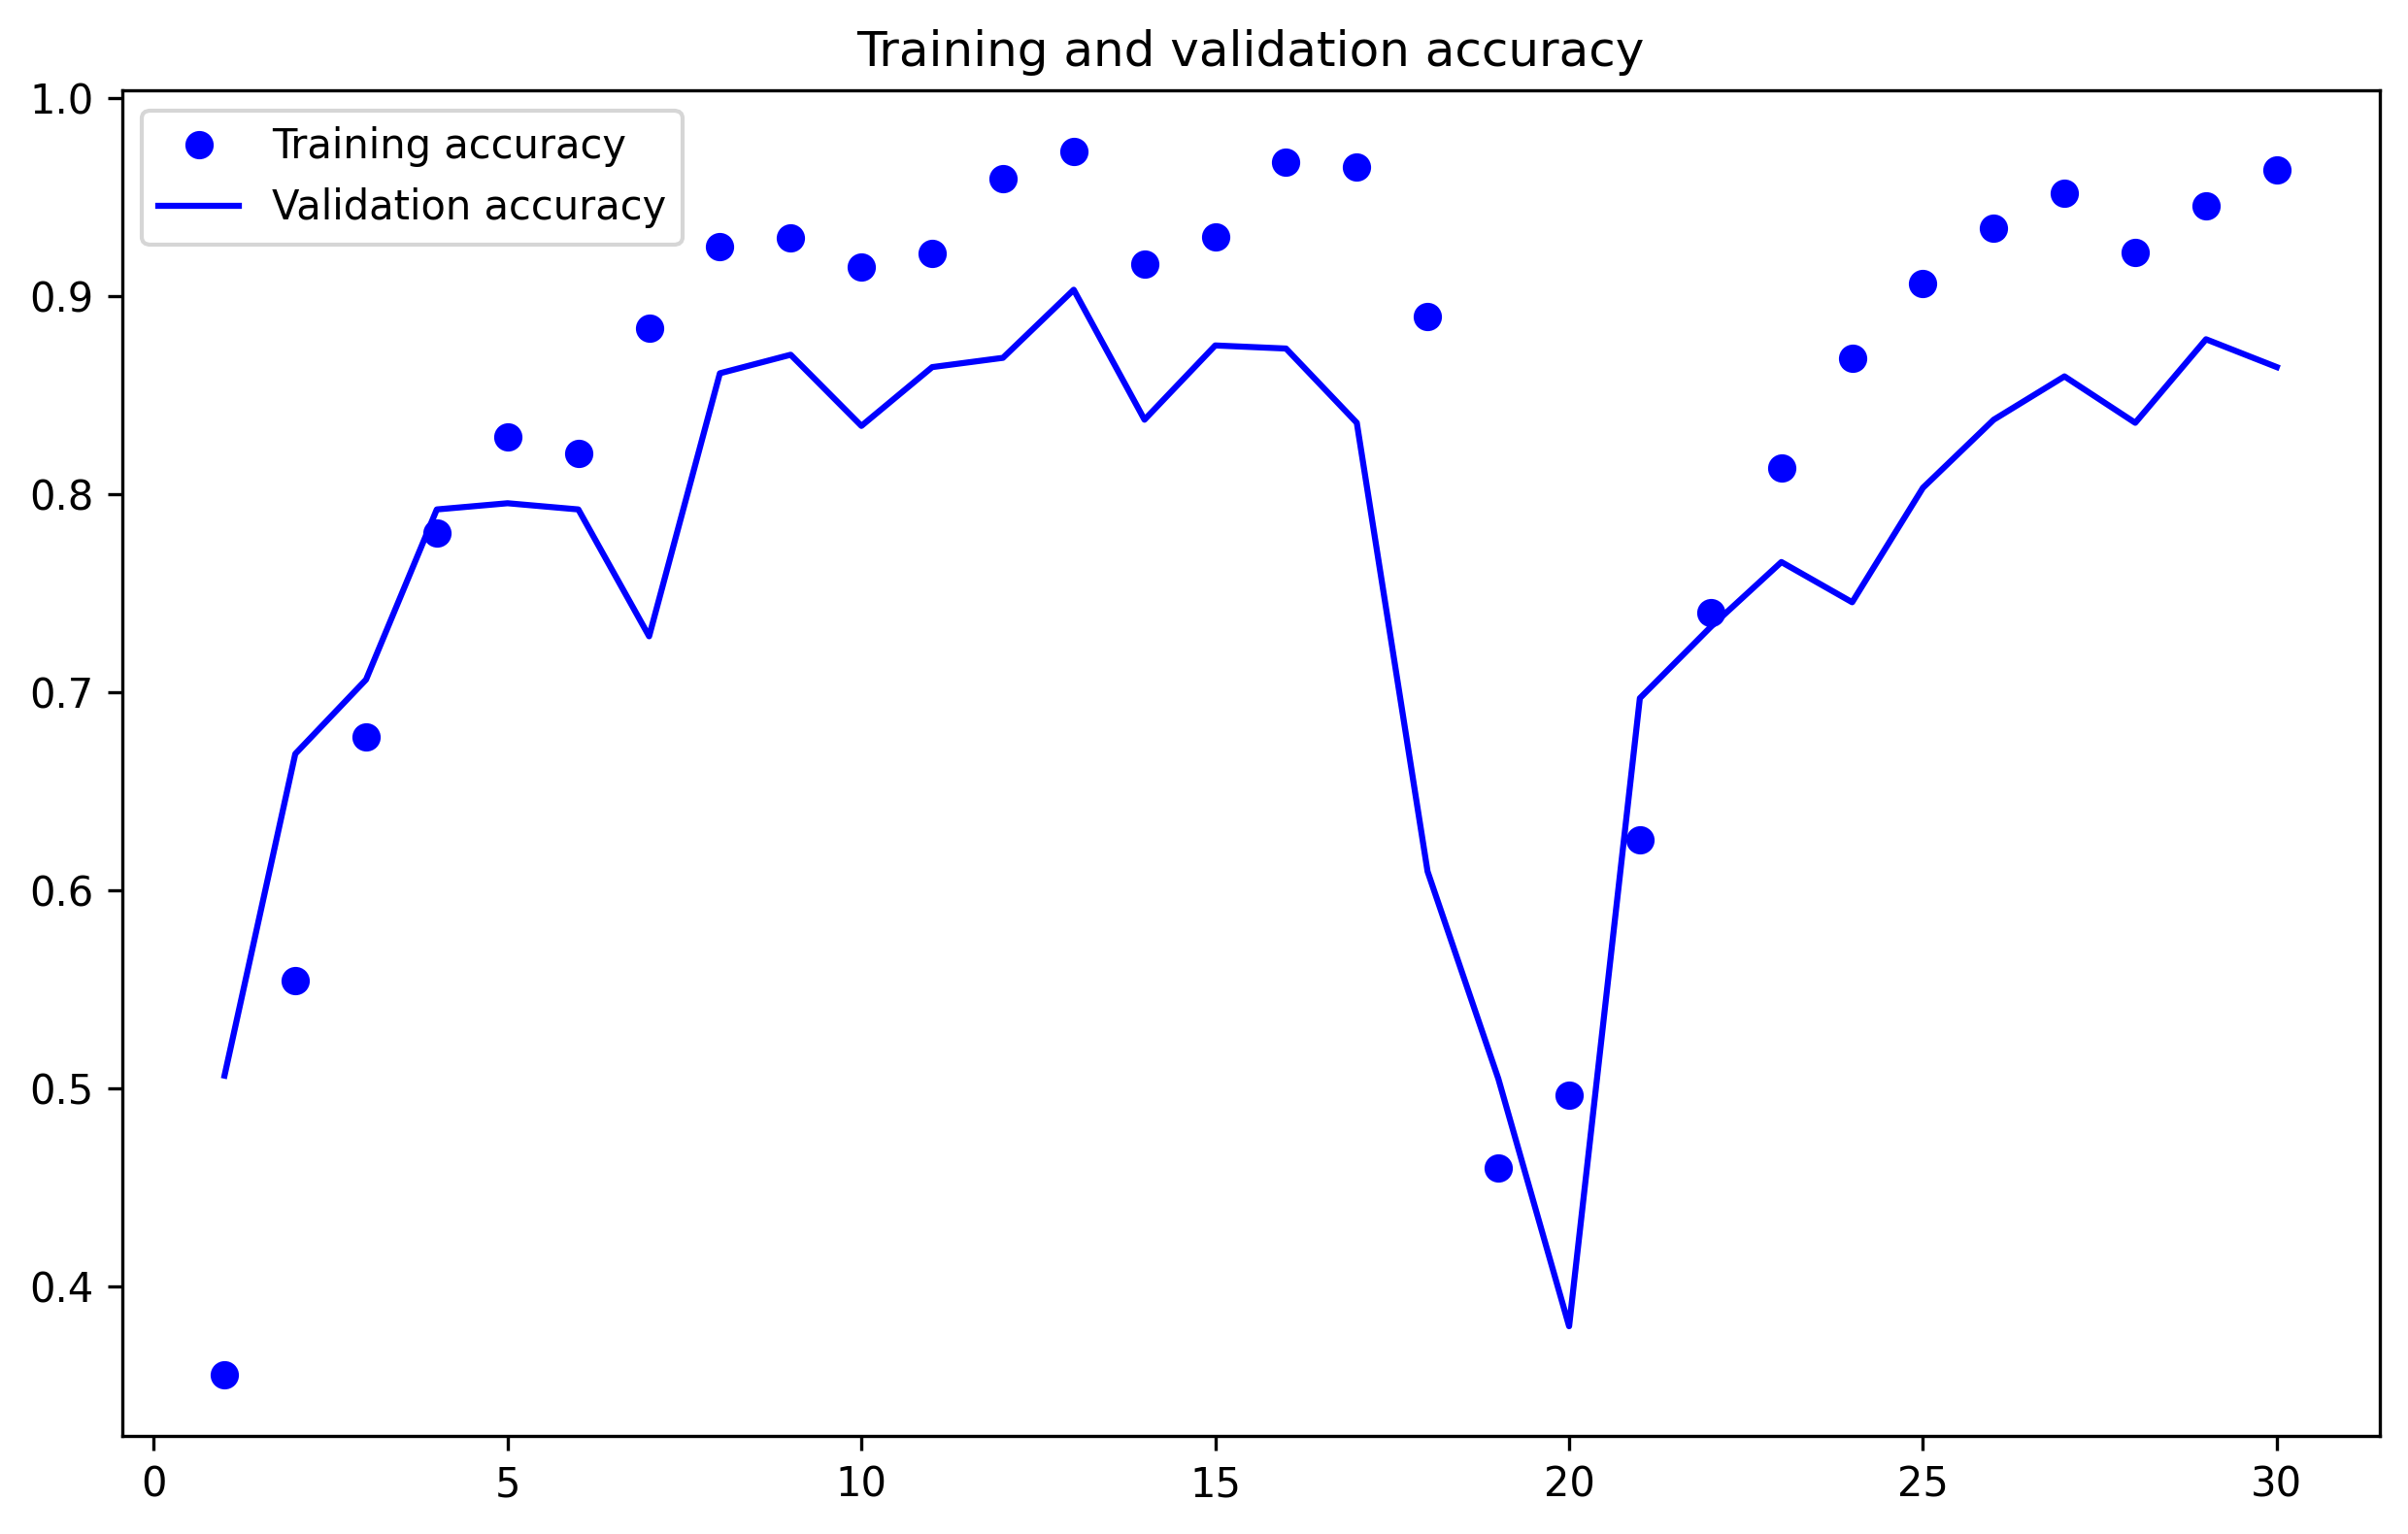

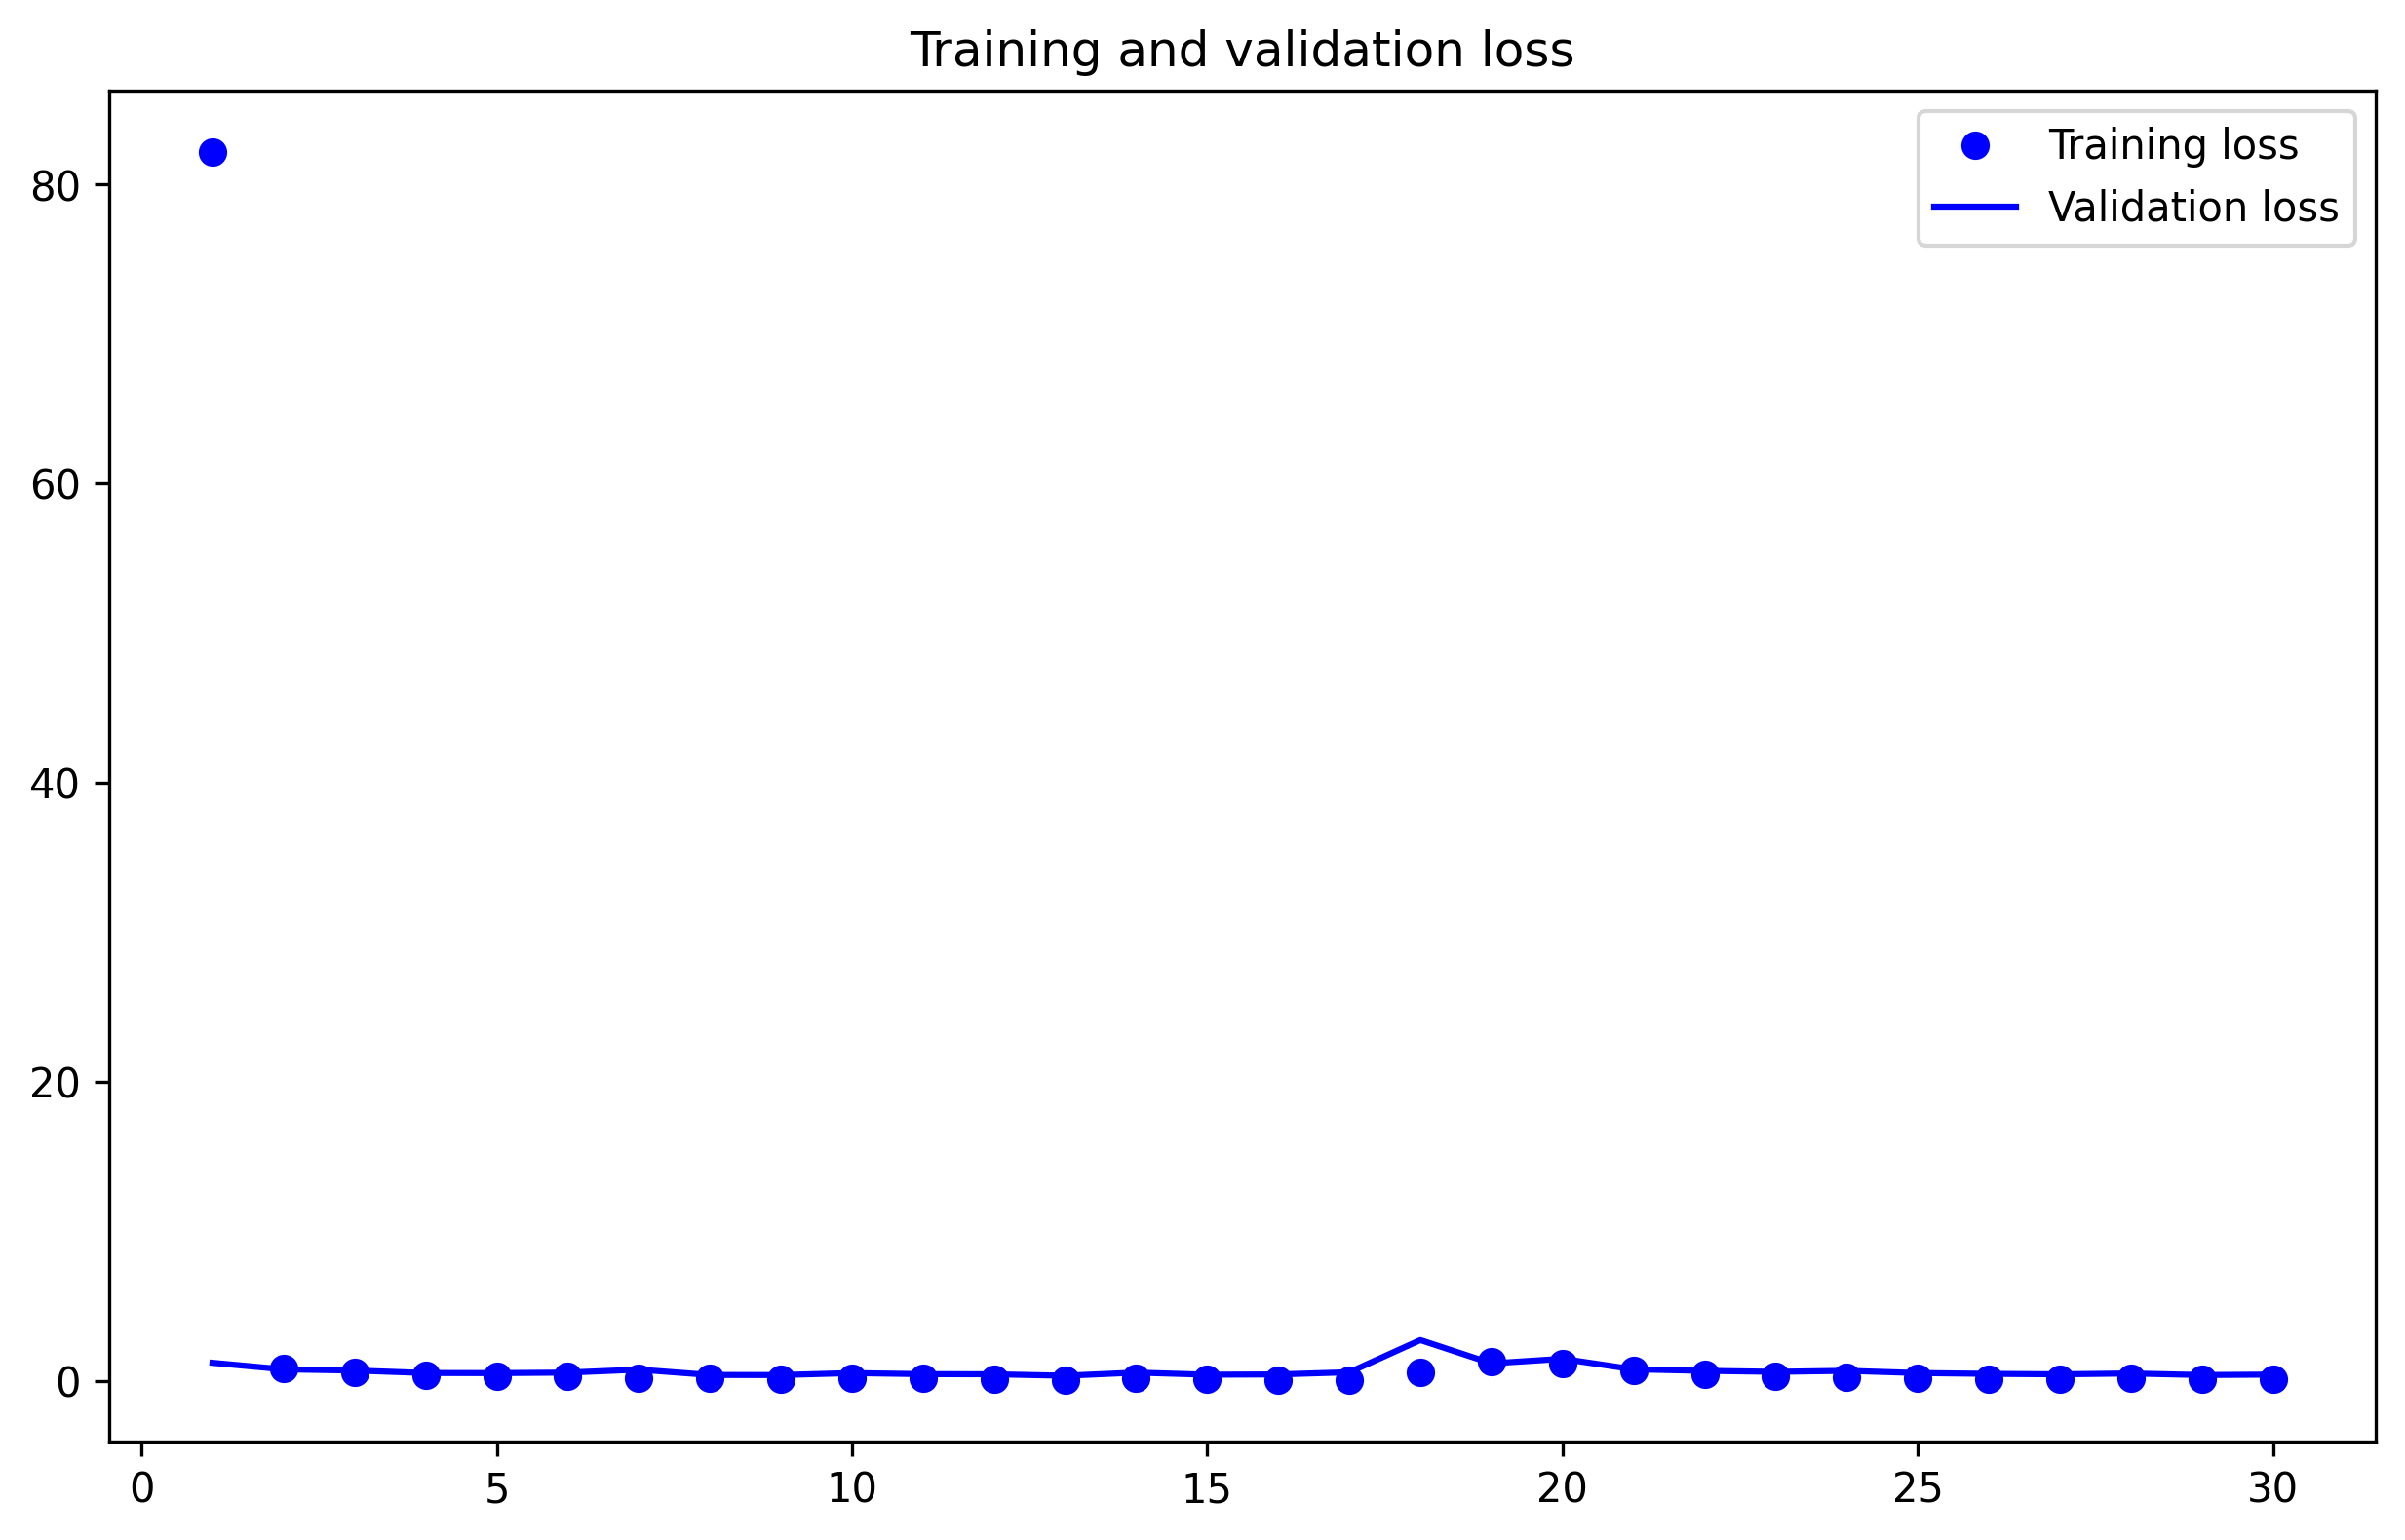

In [19]:
accuracy = history_1.history["accuracy"]
val_accuracy = history_1.history["val_accuracy"]
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

* The model 1 has stopped by epoch 15 because we have used early stopping with a patience of 5.

## *Fit Model 2*

In [20]:
history_2 = model_less_complex.fit(train_data, 
            epochs = 30, 
            validation_data = val_data,
            class_weight = class_weights) 
            # callbacks = check_callbacks_2)

# Extract the history into a pandas DataFrame
history_2_df = pd.DataFrame(history_2.history)

# Add the epoch number
history_2_df['Epoch'] = history_2_df.index + 1

# Reorder the DataFrame such that 'Epoch' is the first column
history_2_df = history_2_df[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

# Print the DataFrame to see the table
print(history_2_df)

Epoch 1/30
160/160 [==============================] - 10s 58ms/step - loss: 428.1404 - accuracy: 0.3434 - val_loss: 91.9722 - val_accuracy: 0.4266
Epoch 2/30
160/160 [==============================] - 9s 58ms/step - loss: 21.9514 - accuracy: 0.6693 - val_loss: 8.6956 - val_accuracy: 0.7547
Epoch 3/30
160/160 [==============================] - 10s 59ms/step - loss: 2.3689 - accuracy: 0.8484 - val_loss: 2.2950 - val_accuracy: 0.8797
Epoch 4/30
160/160 [==============================] - 9s 59ms/step - loss: 0.9059 - accuracy: 0.9094 - val_loss: 2.7839 - val_accuracy: 0.8516
Epoch 5/30
160/160 [==============================] - 10s 60ms/step - loss: 2.2467 - accuracy: 0.9074 - val_loss: 12.9663 - val_accuracy: 0.8047
Epoch 6/30
160/160 [==============================] - 10s 60ms/step - loss: 2.2092 - accuracy: 0.9148 - val_loss: 1.4069 - val_accuracy: 0.9094
Epoch 7/30
160/160 [==============================] - 9s 58ms/step - loss: 0.1720 - accuracy: 0.9740 - val_loss: 0.9554 - val_accurac

## *Loss & Accuracy : Model 2*

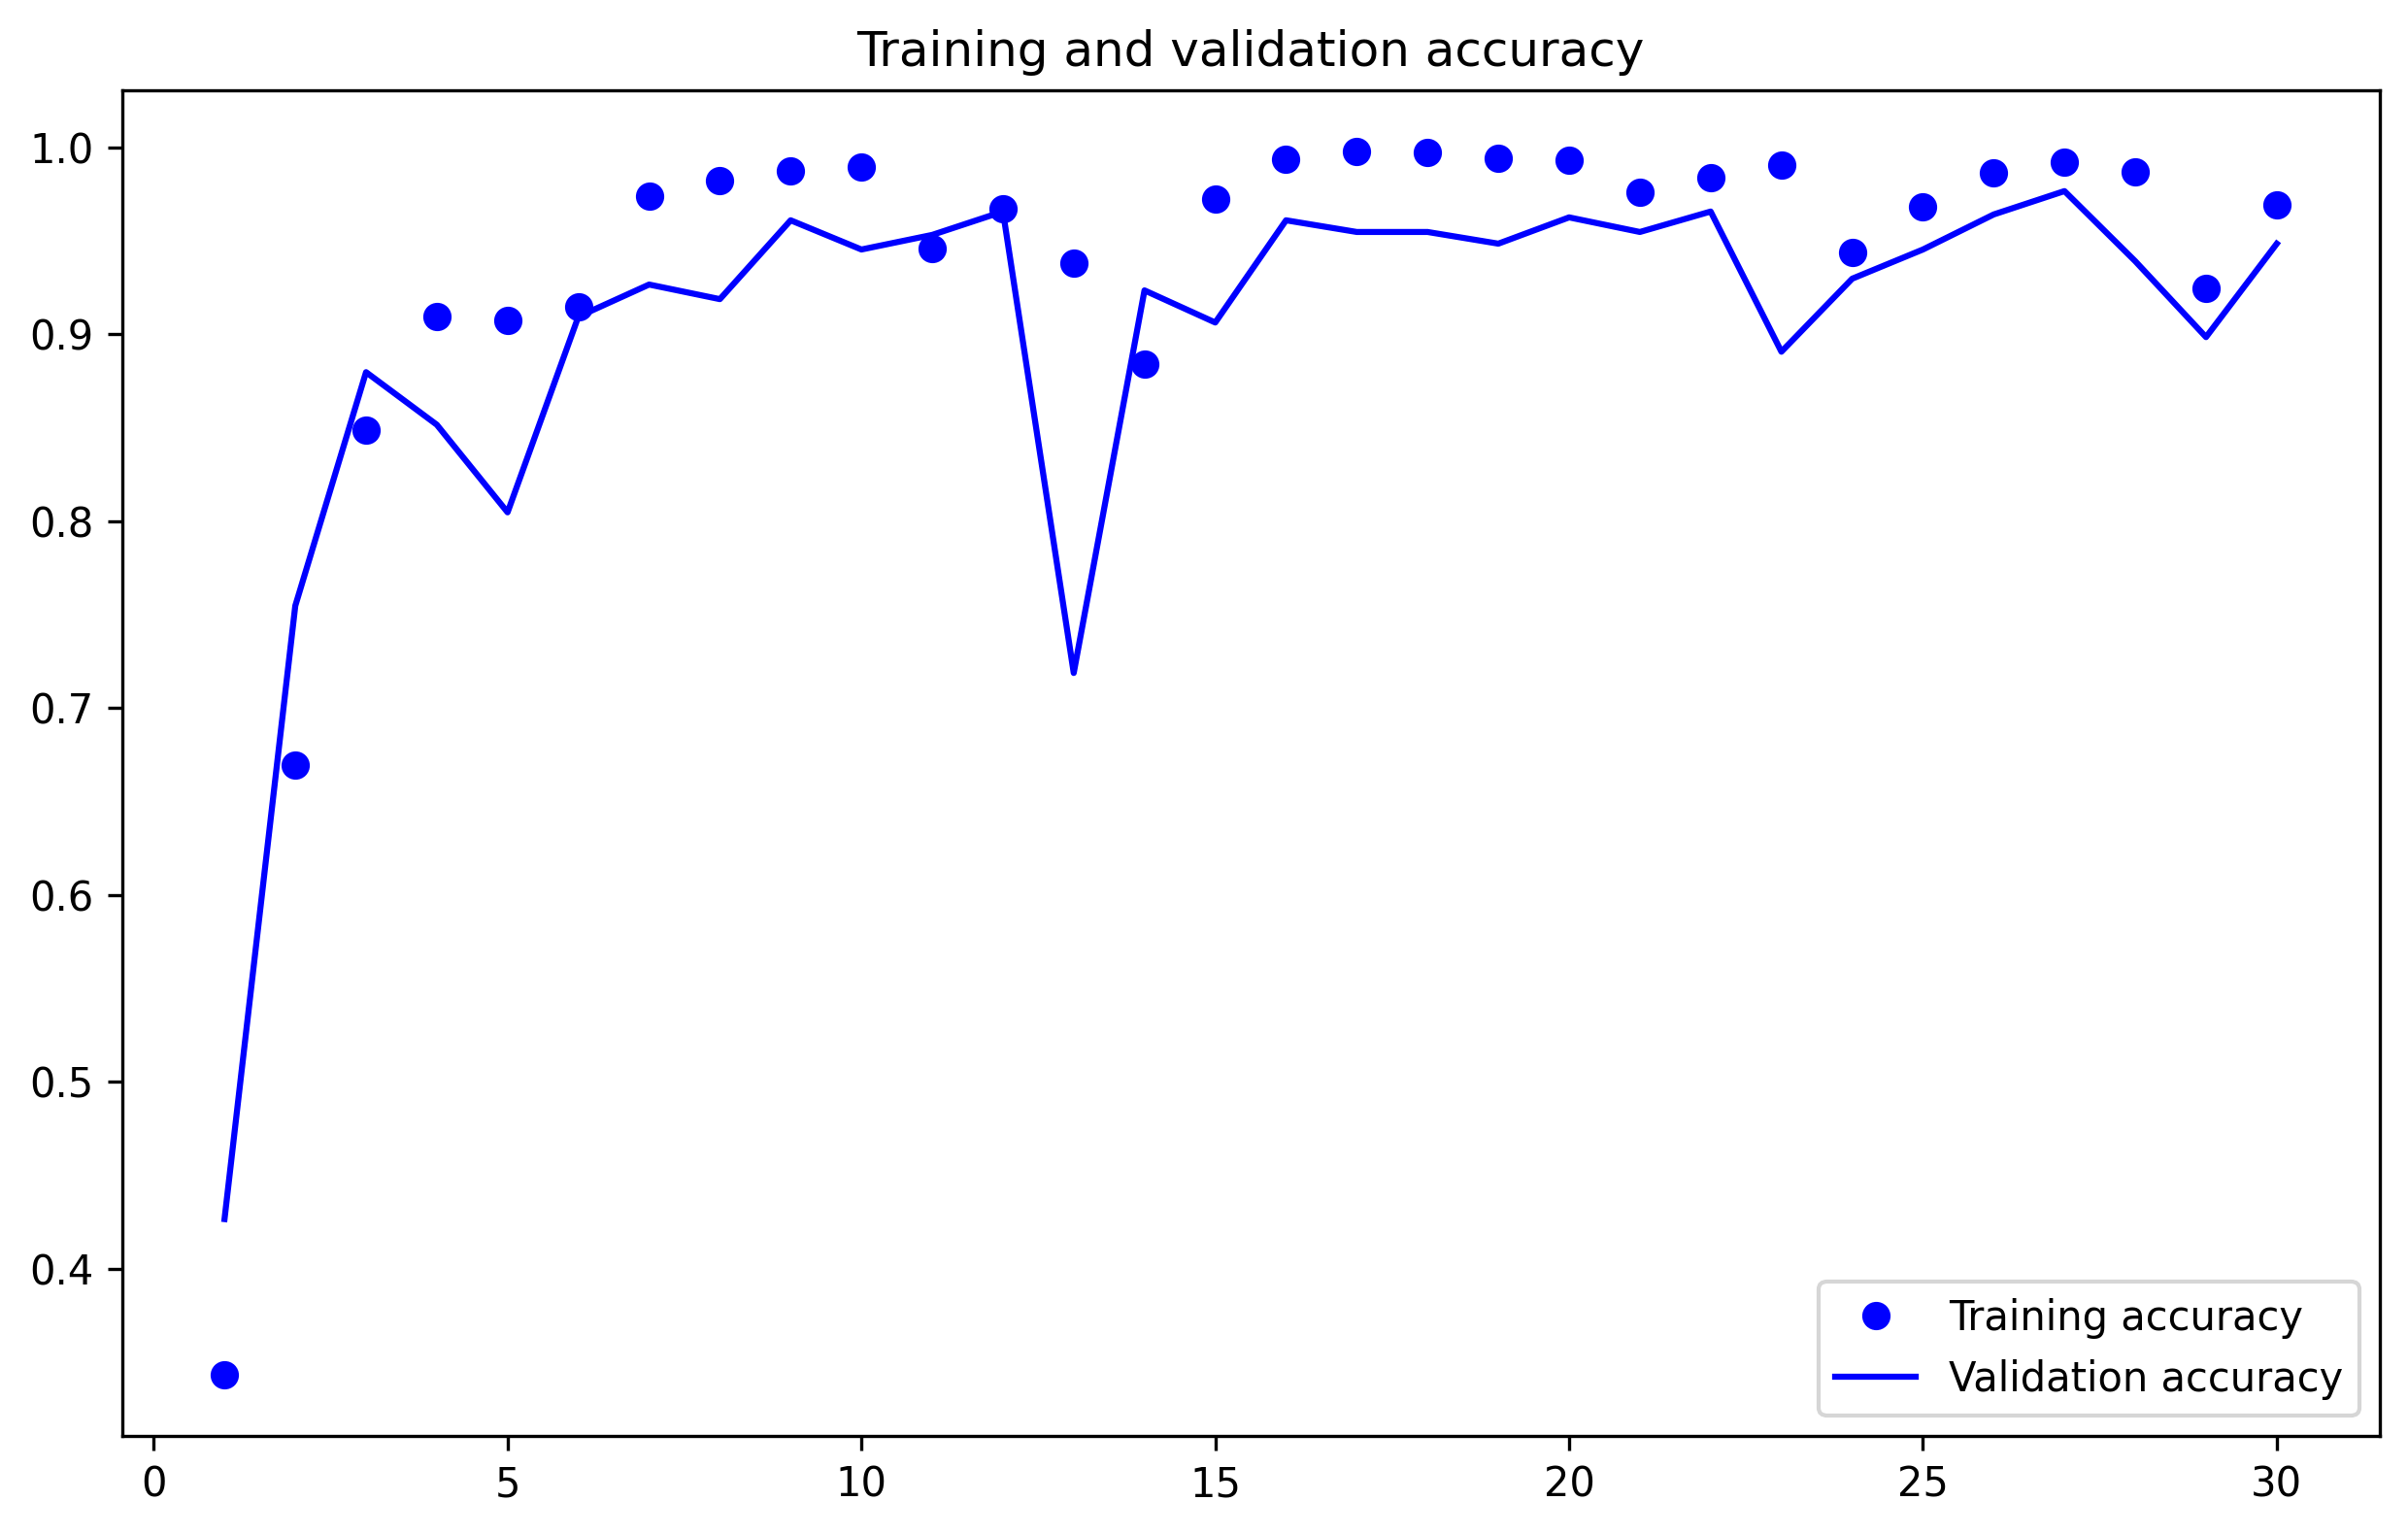

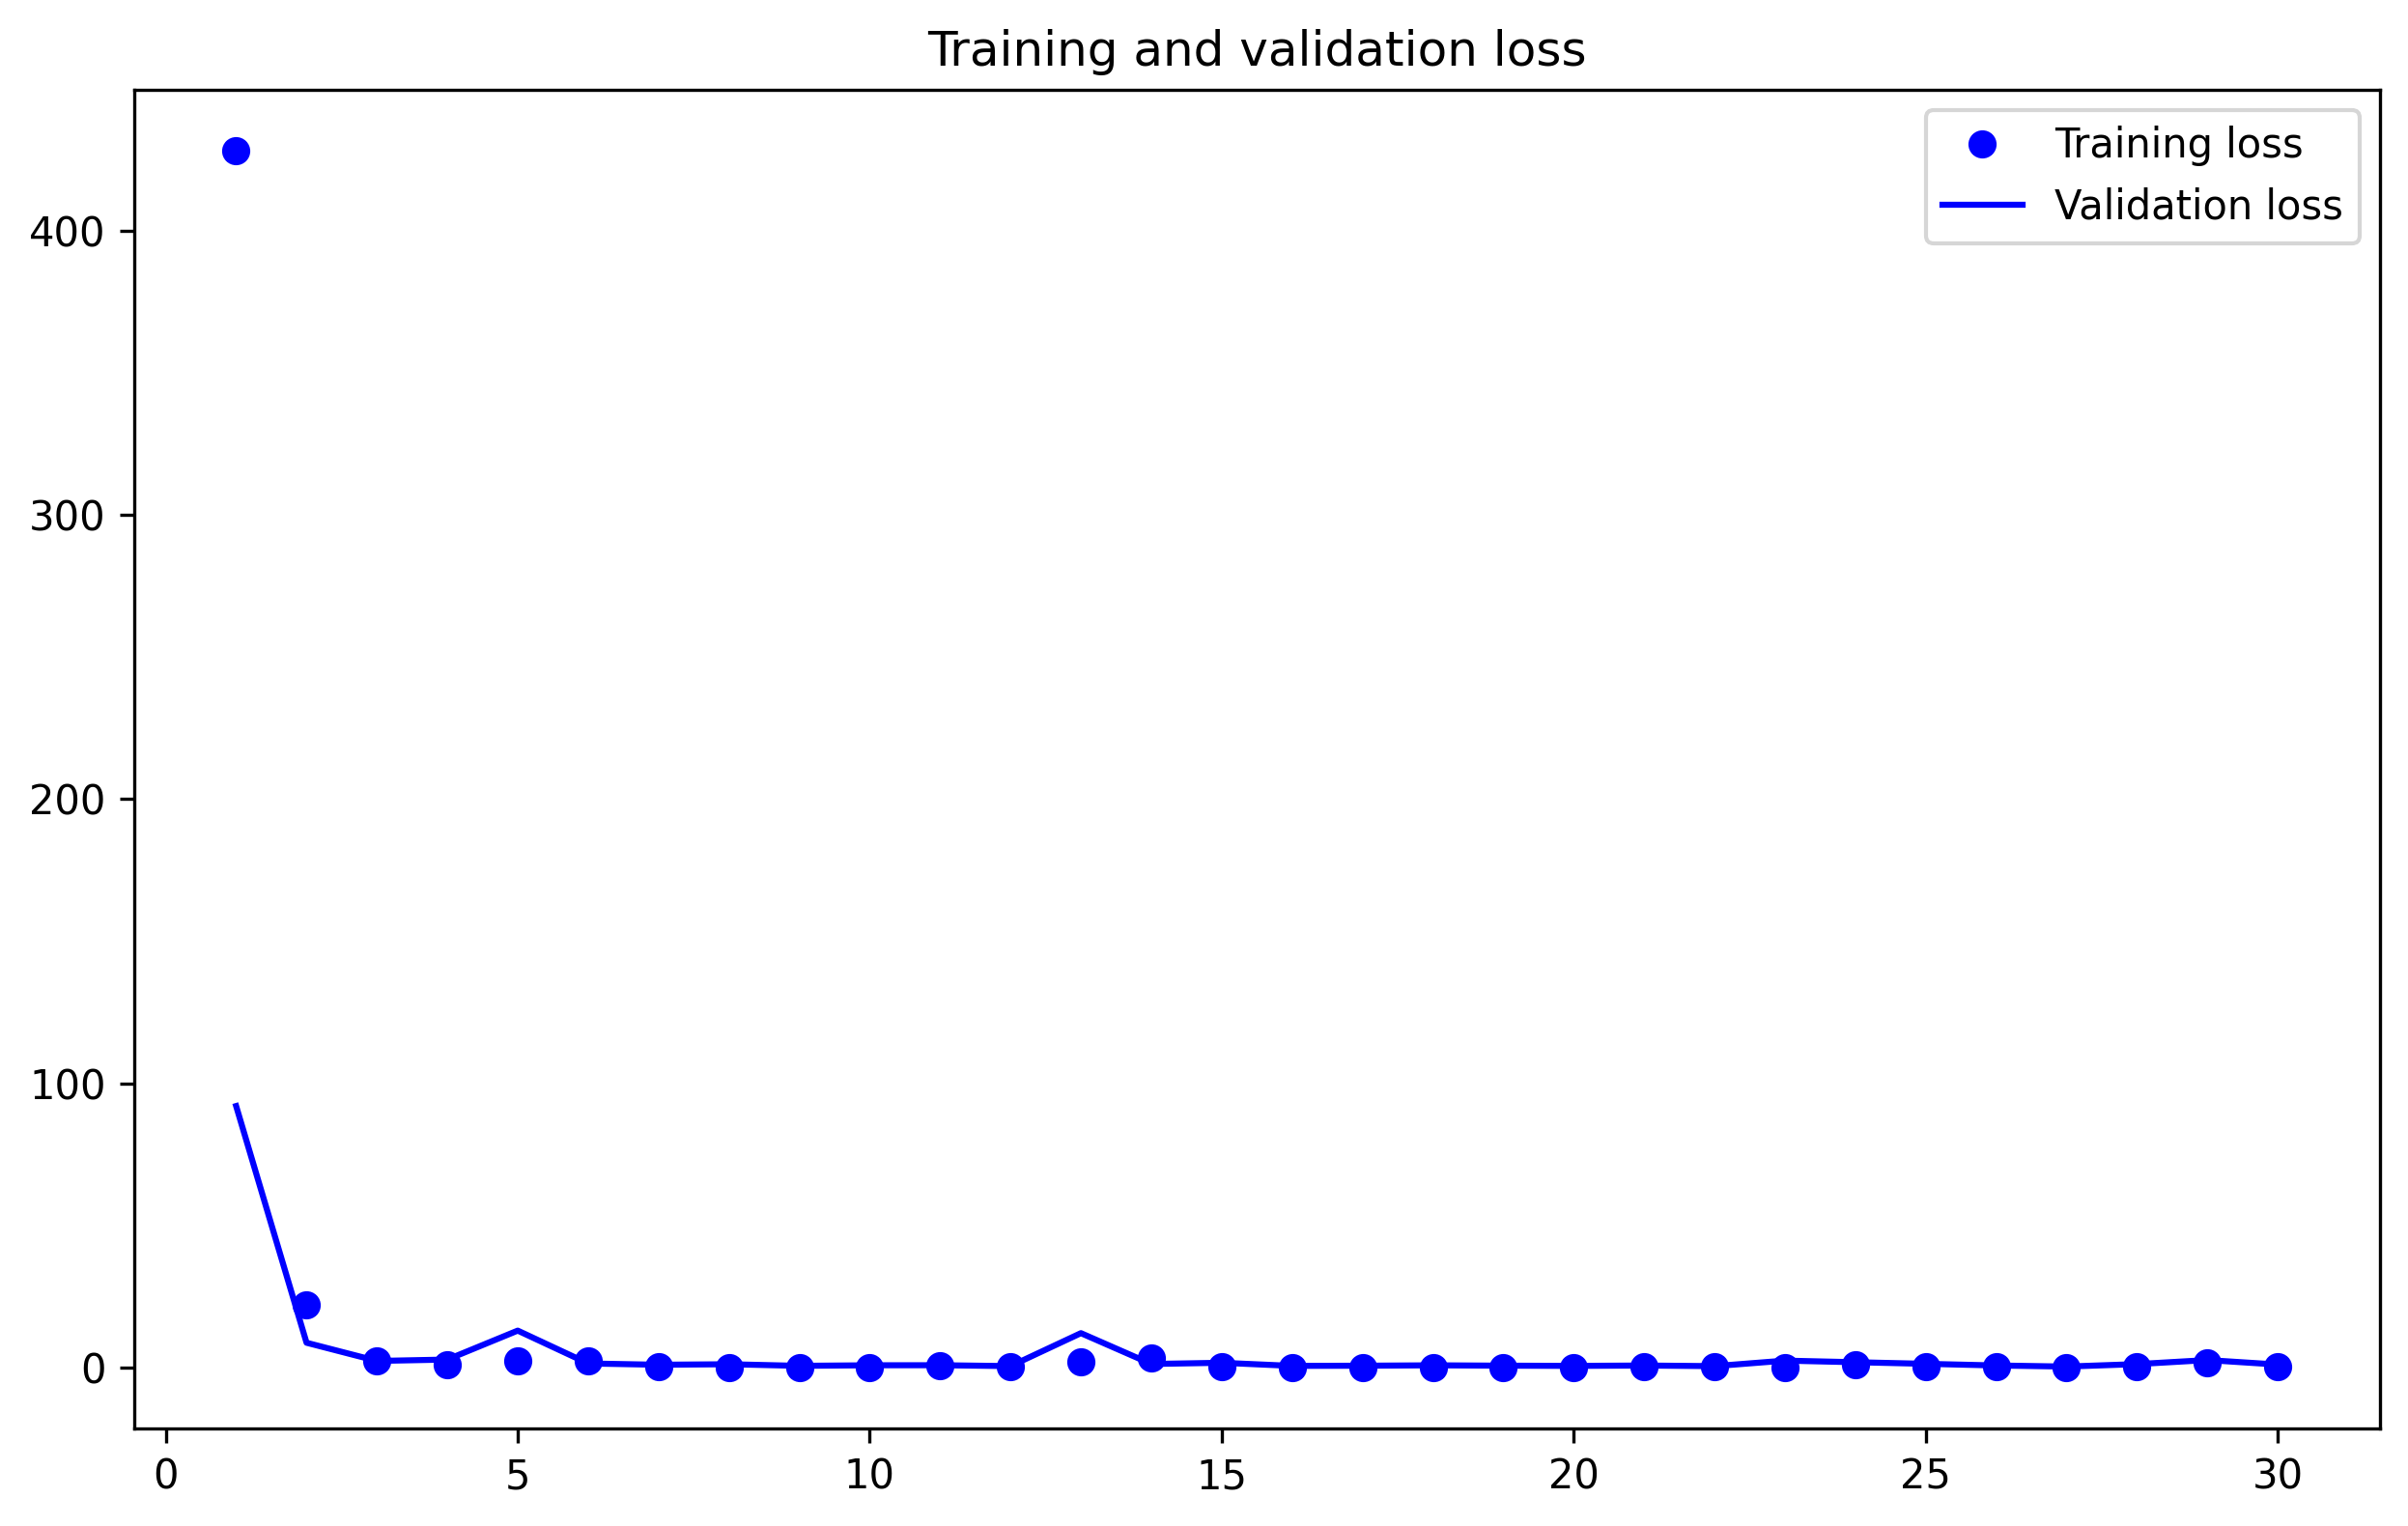

In [21]:
accuracy = history_2.history["accuracy"]
val_accuracy = history_2.history["val_accuracy"]
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### **Loss**

* In the first model, the training loss decreases smoothly and the validation loss decreases and then shows minor fluctuations. This indicates that the model is learning effectively, and while there's a hint of variance in the validation loss, it's not significant.
* In the second model, the training loss drops sharply and remains very low, while the validation loss decreases slightly but remains mostly flat. This suggests that the model may not be improving significantly after the initial epochs.


### **Accuracy Trends:**

* For the first model, both training and validation accuracy improve over time, though the validation accuracy shows more variance. This might be due to the model starting to overfit or due to the complexity of the validation data.
* The second model's accuracy for both training and validation sharply increases and then decreases just as sharply. This volatility could be a sign of overfitting, an inappropriate learning rate, or instability in the training process.

### **Gap Between Training and Validation:**

* The first model shows a consistent gap between training and validation accuracy, suggesting a stable but present difference in performance on training versus unseen data.
* The second model's gap between training and validation accuracy widens significantly after the initial epochs, which is indicative of overfitting.


# 5. Evaluation - Neural Network Model 1 and Model 2

## 5.1. Comparison of training metrics between two different machine learning models over various epochs.

In [22]:
import pandas as pd

# Assuming history_1_df and history_2_df are already defined DataFrames

# Get the last 5 entries of each DataFrame
last_five_history_1 = history_1_df.tail(5)
last_five_history_2 = history_2_df.tail(5)

# Add prefix to the columns to indicate the model
last_five_history_1 = last_five_history_1.add_prefix('Model 1 ')
last_five_history_2 = last_five_history_2.add_prefix('Model 2 ')

# Concatenate the results side by side
combined_last_fives = pd.concat([last_five_history_1.reset_index(drop=True), last_five_history_2.reset_index(drop=True)], axis=1)

# Print the combined DataFrame
combined_last_fives


,Model 1 Epoch,Model 1 loss,Model 1 accuracy,Model 1 val_loss,Model 1 val_accuracy,Model 2 Epoch,Model 2 loss,Model 2 accuracy,Model 2 val_loss,Model 2 val_accuracy
0,26,0.116636,0.934375,0.457023,0.837500,26,0.139663,0.986133,0.700931,0.964063
1,27,0.091607,0.951758,0.424967,0.859375,27,0.079389,0.991992,0.314341,0.976562
2,28,0.137624,0.921875,0.482901,0.835938,28,0.165470,0.986719,1.179498,0.939062
3,29,0.102287,0.945703,0.376570,0.878125,29,1.559823,0.924414,2.608165,0.898438
4,30,0.070764,0.963672,0.407775,0.864062,30,0.348203,0.968945,1.024596,0.948438


## 5.2. Evaluating with test Data

In [23]:
# model 1
print(model_1.evaluate(test_data))

# model 2

print(model_less_complex.evaluate(test_data))

20/20 [==============================] - 2s 32ms/step - loss: 0.5688 - accuracy: 0.8438
[0.5688387751579285, 0.84375]
20/20 [==============================] - 1s 16ms/step - loss: 1.6502 - accuracy: 0.9281
[1.6501655578613281, 0.9281250238418579]


* Model 1 is performing better on the test data, with a higher accuracy and a lower loss compared to Model 2. This suggests that Model 1 generalizes better to unseen data and is more reliable for making predictions

                                 First model is the better one                                                   

## 5.3. Evaluating the results of the best model

### 5.3.1.  Classification Report

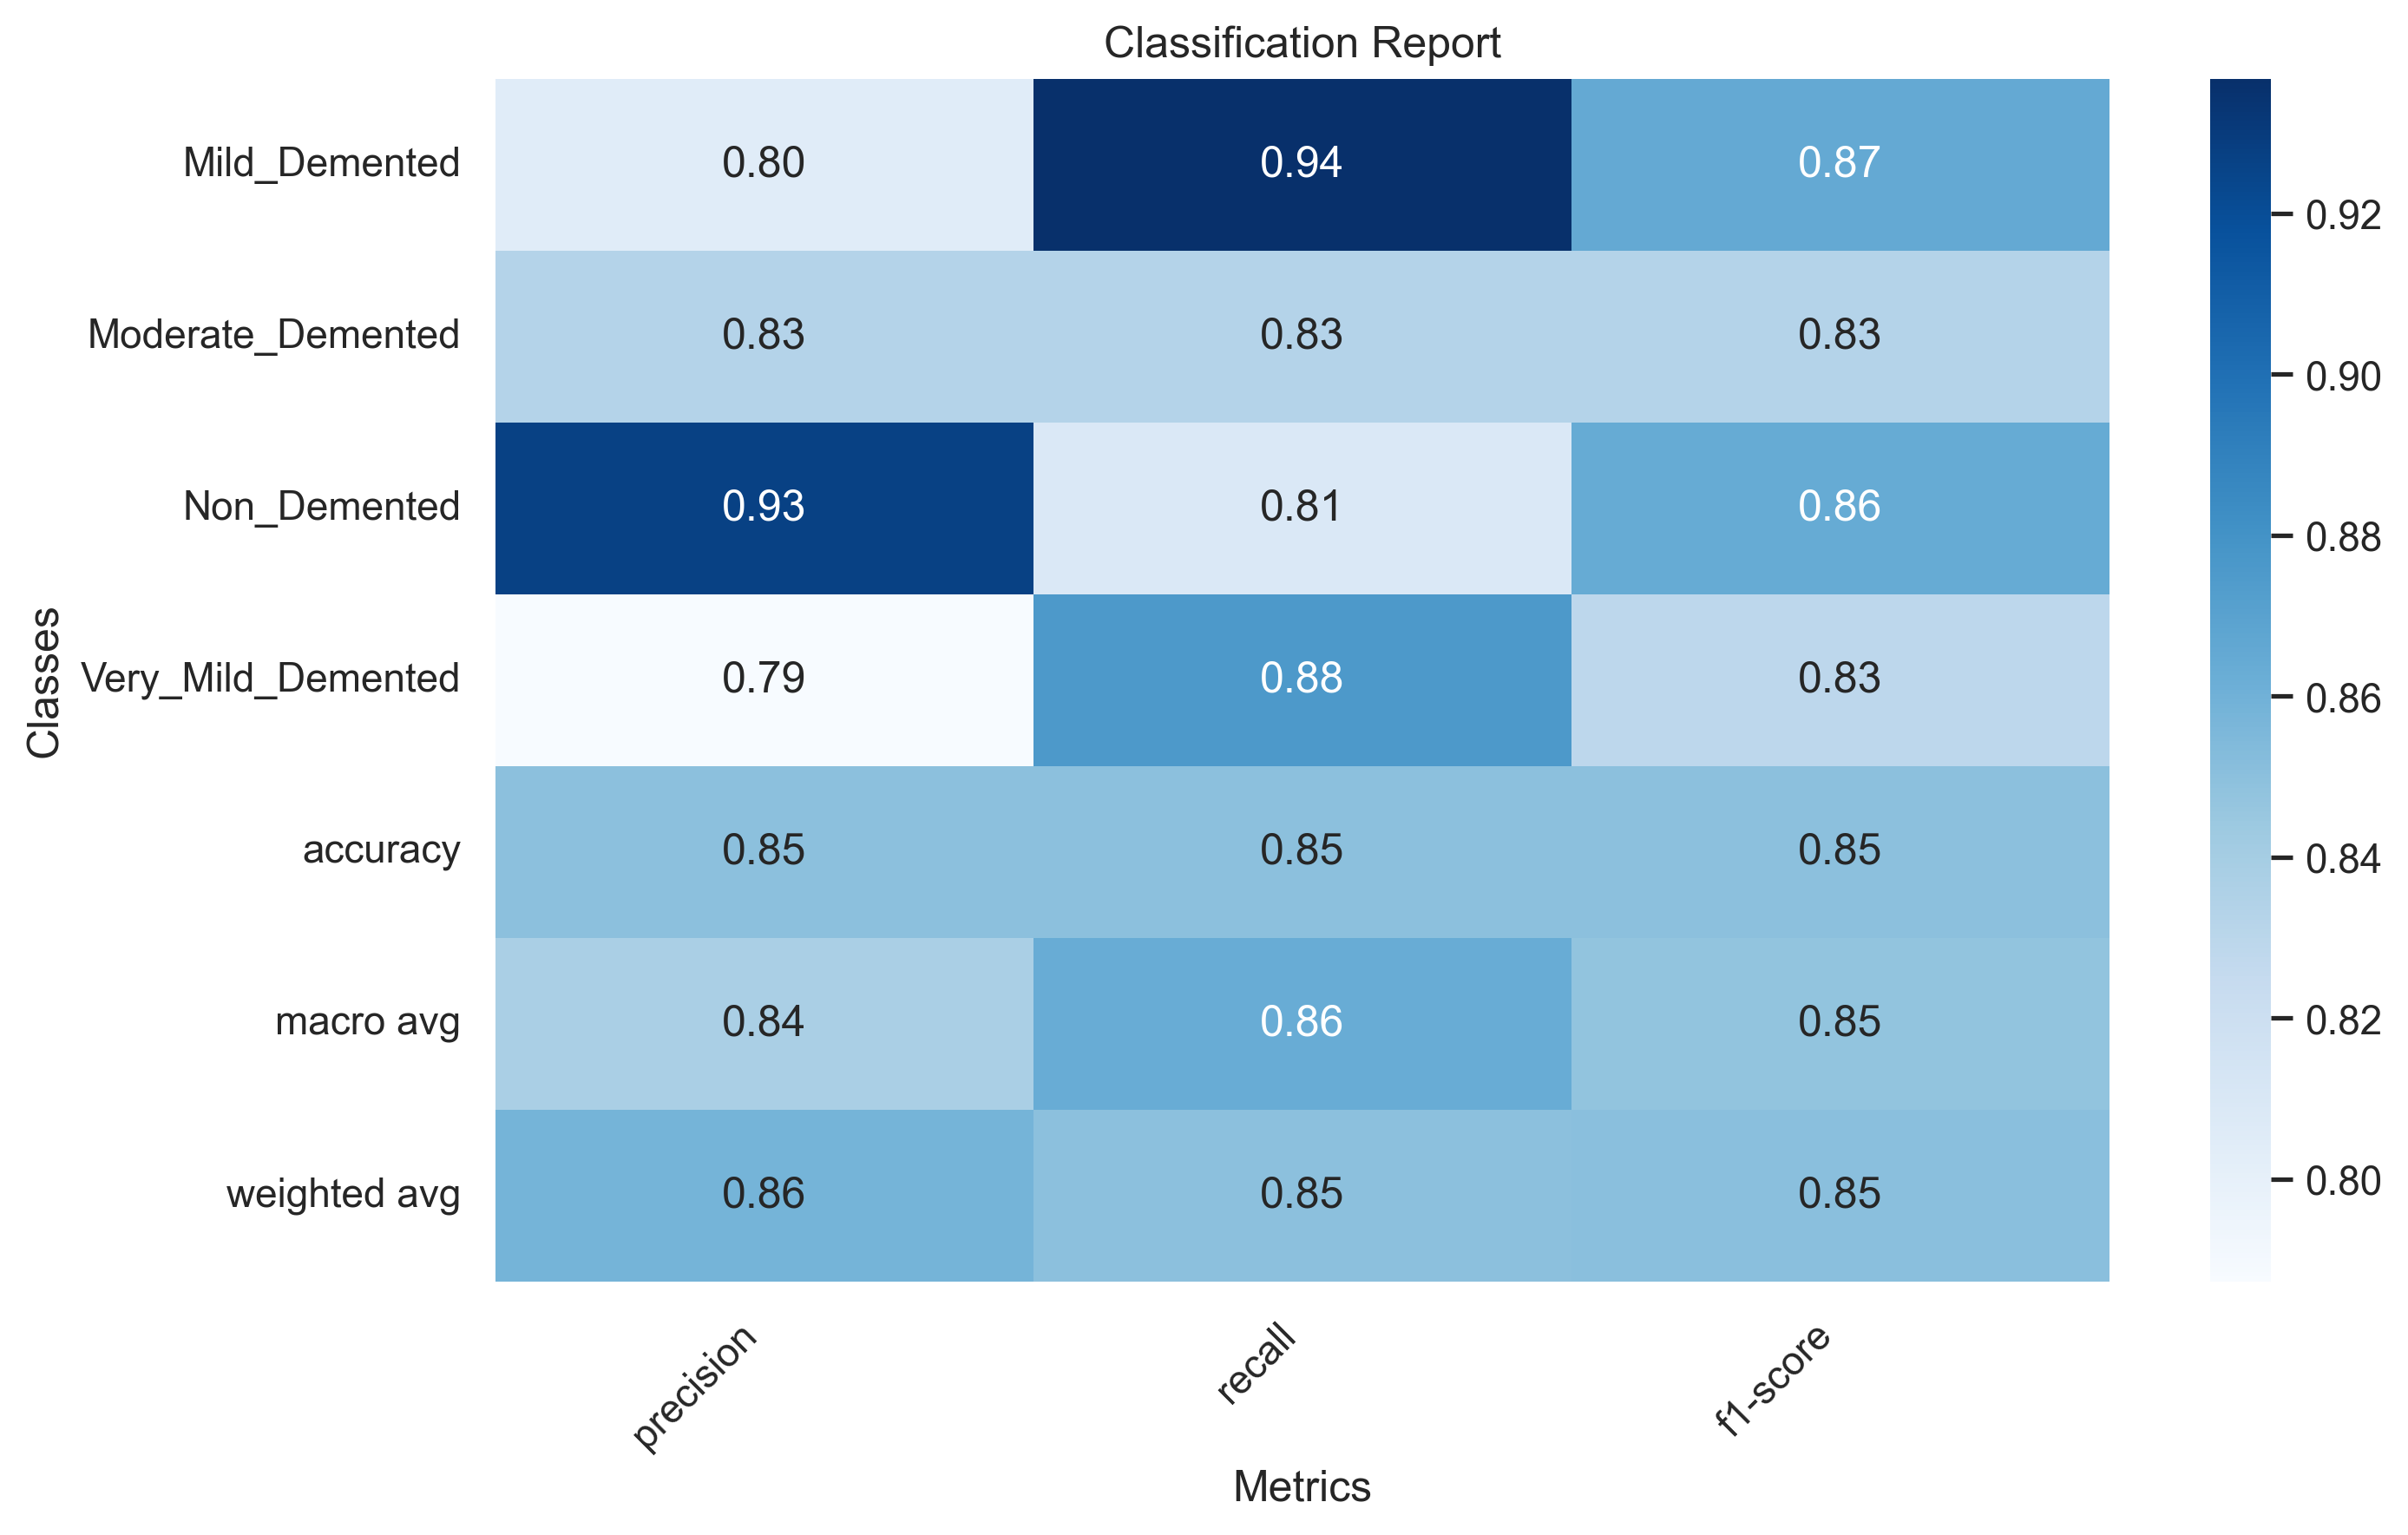

In [24]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model_1.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)
    
predictions = np.array(predictions)
labels = np.array(labels)

report = classification_report(labels, predictions, target_names=class_names, output_dict=True)

# Convert the report dictionary to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Configure the plot with seaborn
sns.set(style="whitegrid")
# Drop the 'support' column to only display the precision, recall, and f1-score
df_plot = df_report.drop(columns=["support"])
# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_plot, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')

# This adjustment helps in case labels overlap with the heatmap cells
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()


The model shows very high precision and recall for the 'Moderate_Demented' class (1.00 for both metrics), which suggests perfect performance for this class. <br>
'Mild_Demented' has the lowest precision (0.87), but still high recall (0.94) and F1-score (0.90).<br>
- A precision of 0.87 for 'Mild_Demented' means that out of all the instances the model predicted as 'Mild_Demented', 87% were actually 'Mild_Demented' according to the ground truth labels.
 - A recall of 0.94 for 'Mild_Demented' means that the model correctly identified 94% of the 'Mild_Demented' cases

'Non_Demented' and 'Very_Mild_Demented' classes also show high performance with precision, recall, and F1-scores all above 0.90.<br>

The overall accuracy of the model is 0.94, which means it correctly predicts 94% of the time.<br>


### 5.3.2. Confusion Matrix

Text(275.24999999999994, 0.5, 'True')

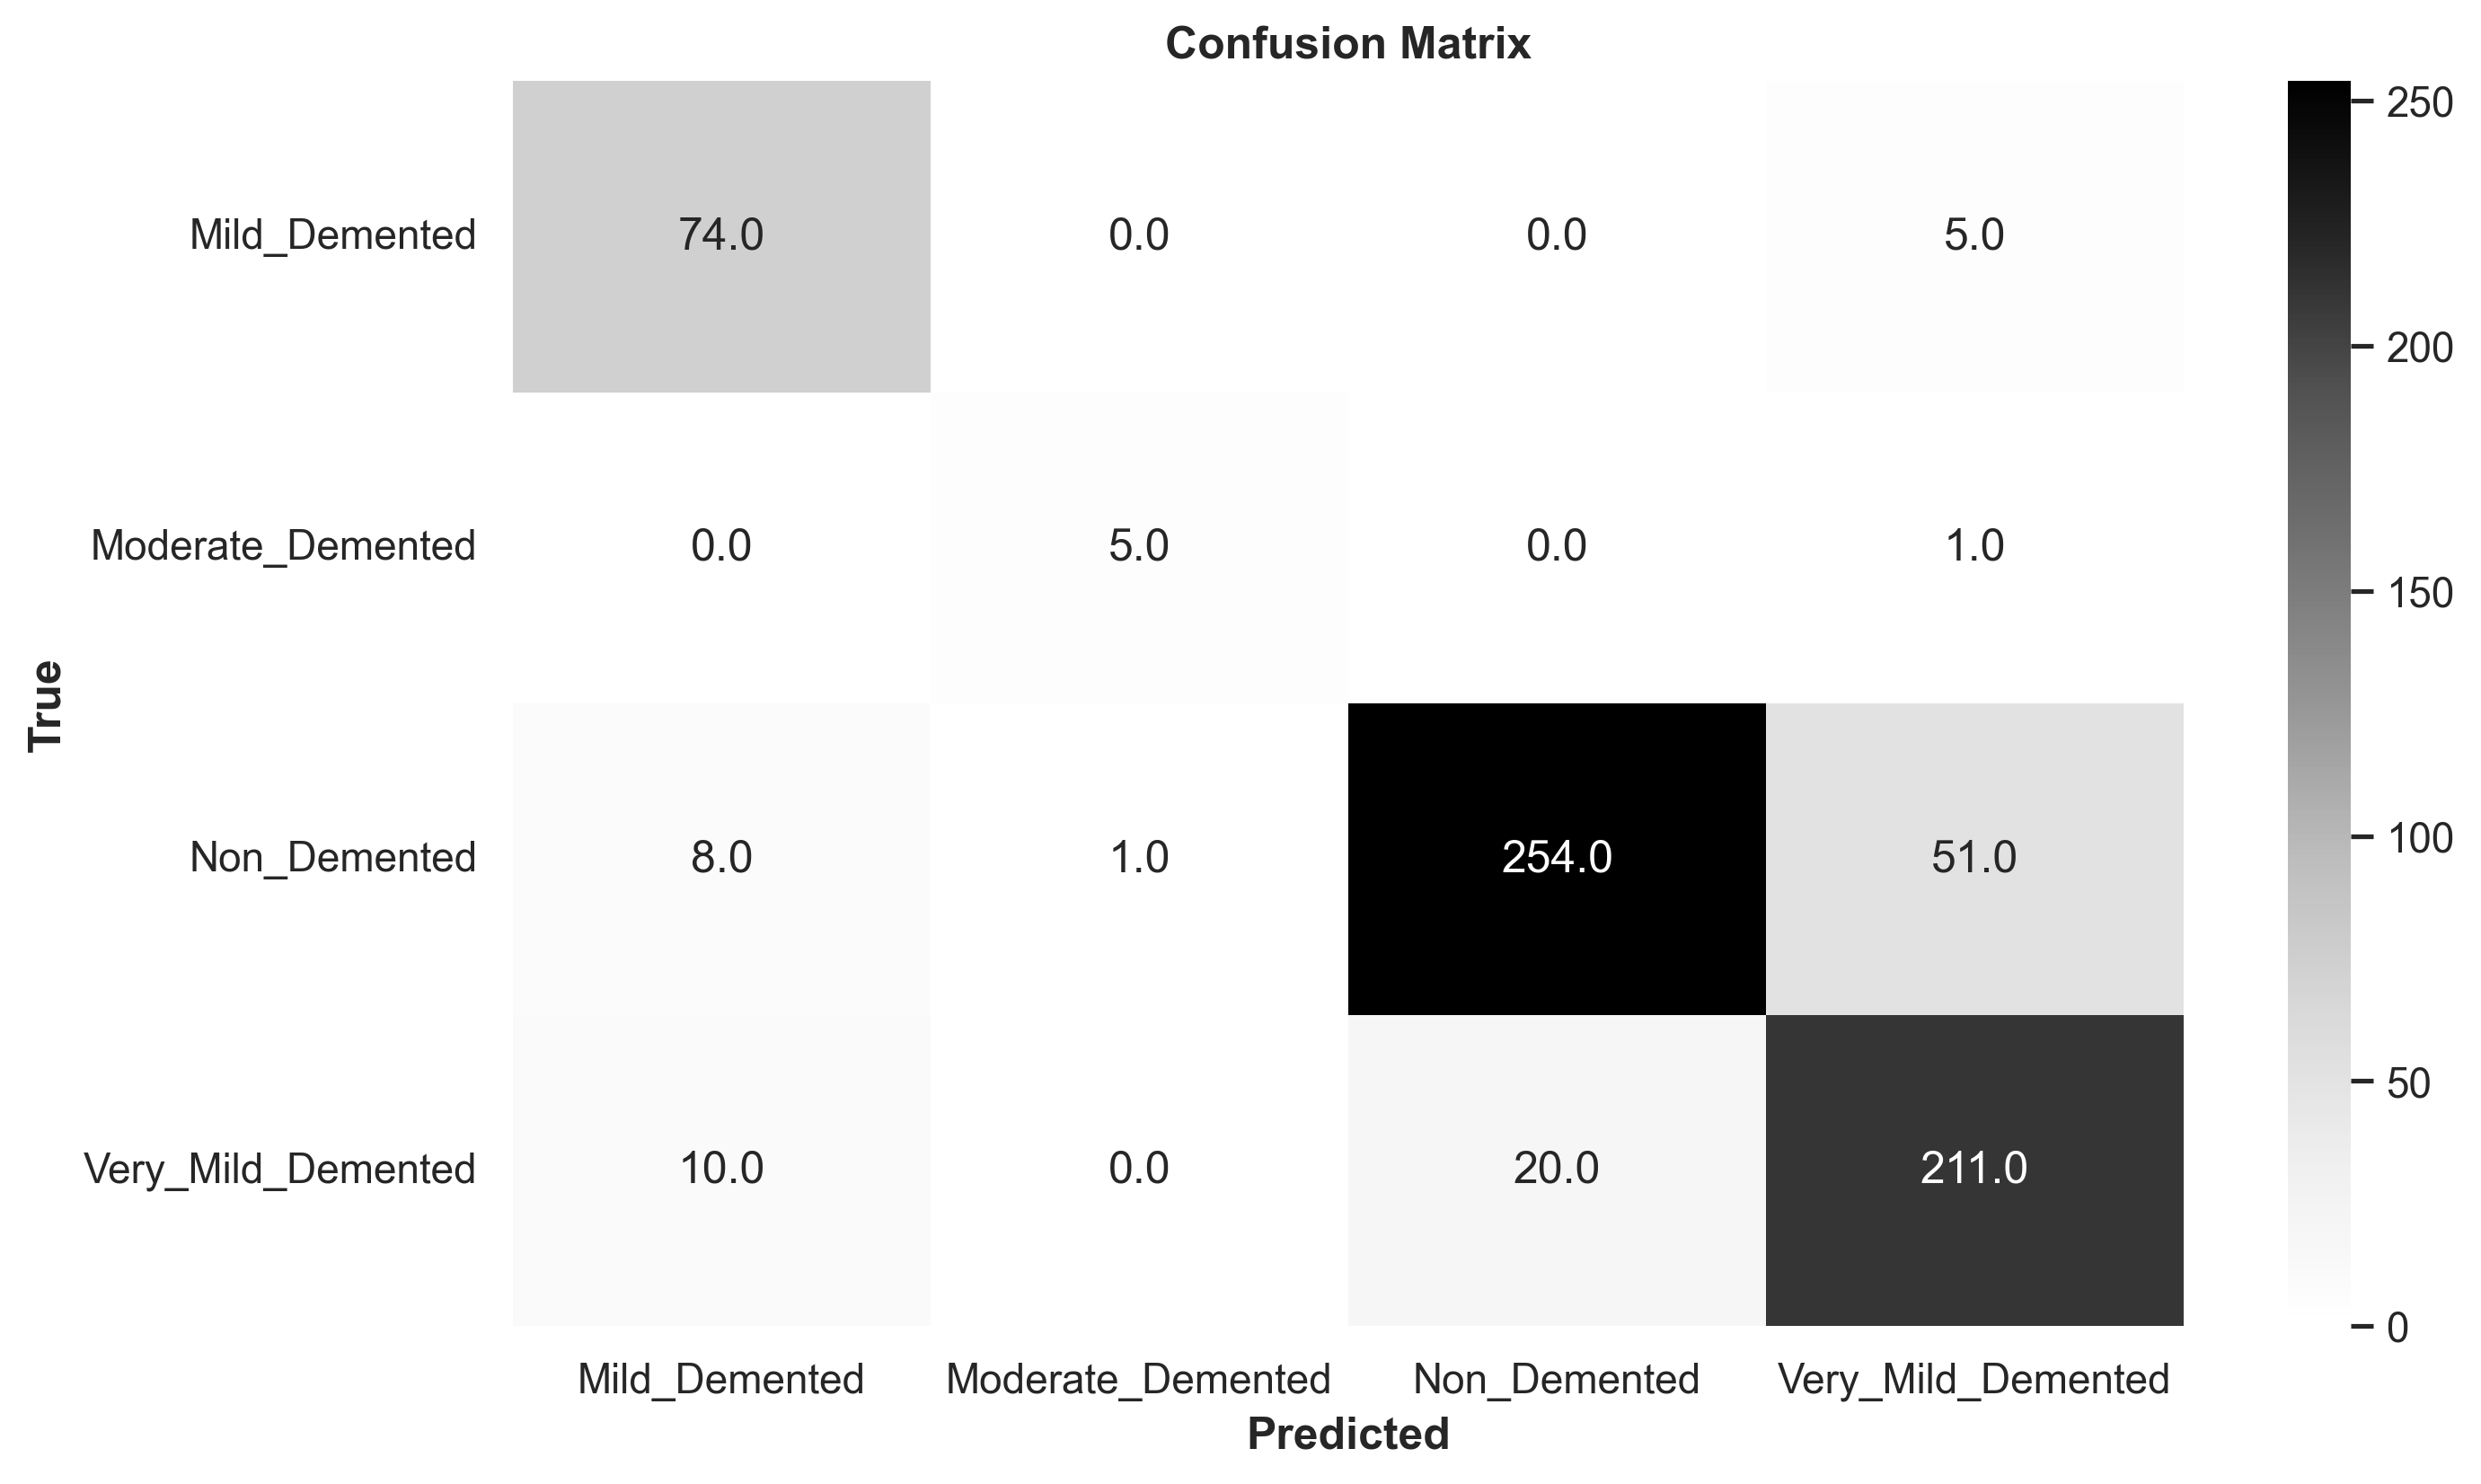

In [25]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

- Mild_Demented: There were 74 true positives, meaning the model correctly predicted 'Mild_Demented' 74 times. It incorrectly predicted 'Mild_Demented' as 'Non_Demented' 2 times, and as 'Very_Mild_Demented' 3 times. <br>
- Moderate_Demented: The model correctly predicted all 4 instances without any misclassification.<br>
- Non_Demented: The model performed well for this class, with 301 correct predictions. However, there were 6 cases where 'Non_Demented' was incorrectly predicted as 'Mild_Demented', and 9 cases where it was incorrectly predicted as 'Very_Mild_Demented'.<br>
- Very_Mild_Demented: The model had 218 correct predictions but also incorrectly classified 6 instances of 'Very_Mild_Demented' as 'Mild_Demented', and 12 instances as 'Non_Demented'.<br>

# 6. Conclusion: Comparing Predicted Classes with the Actual Classes from the Test Data

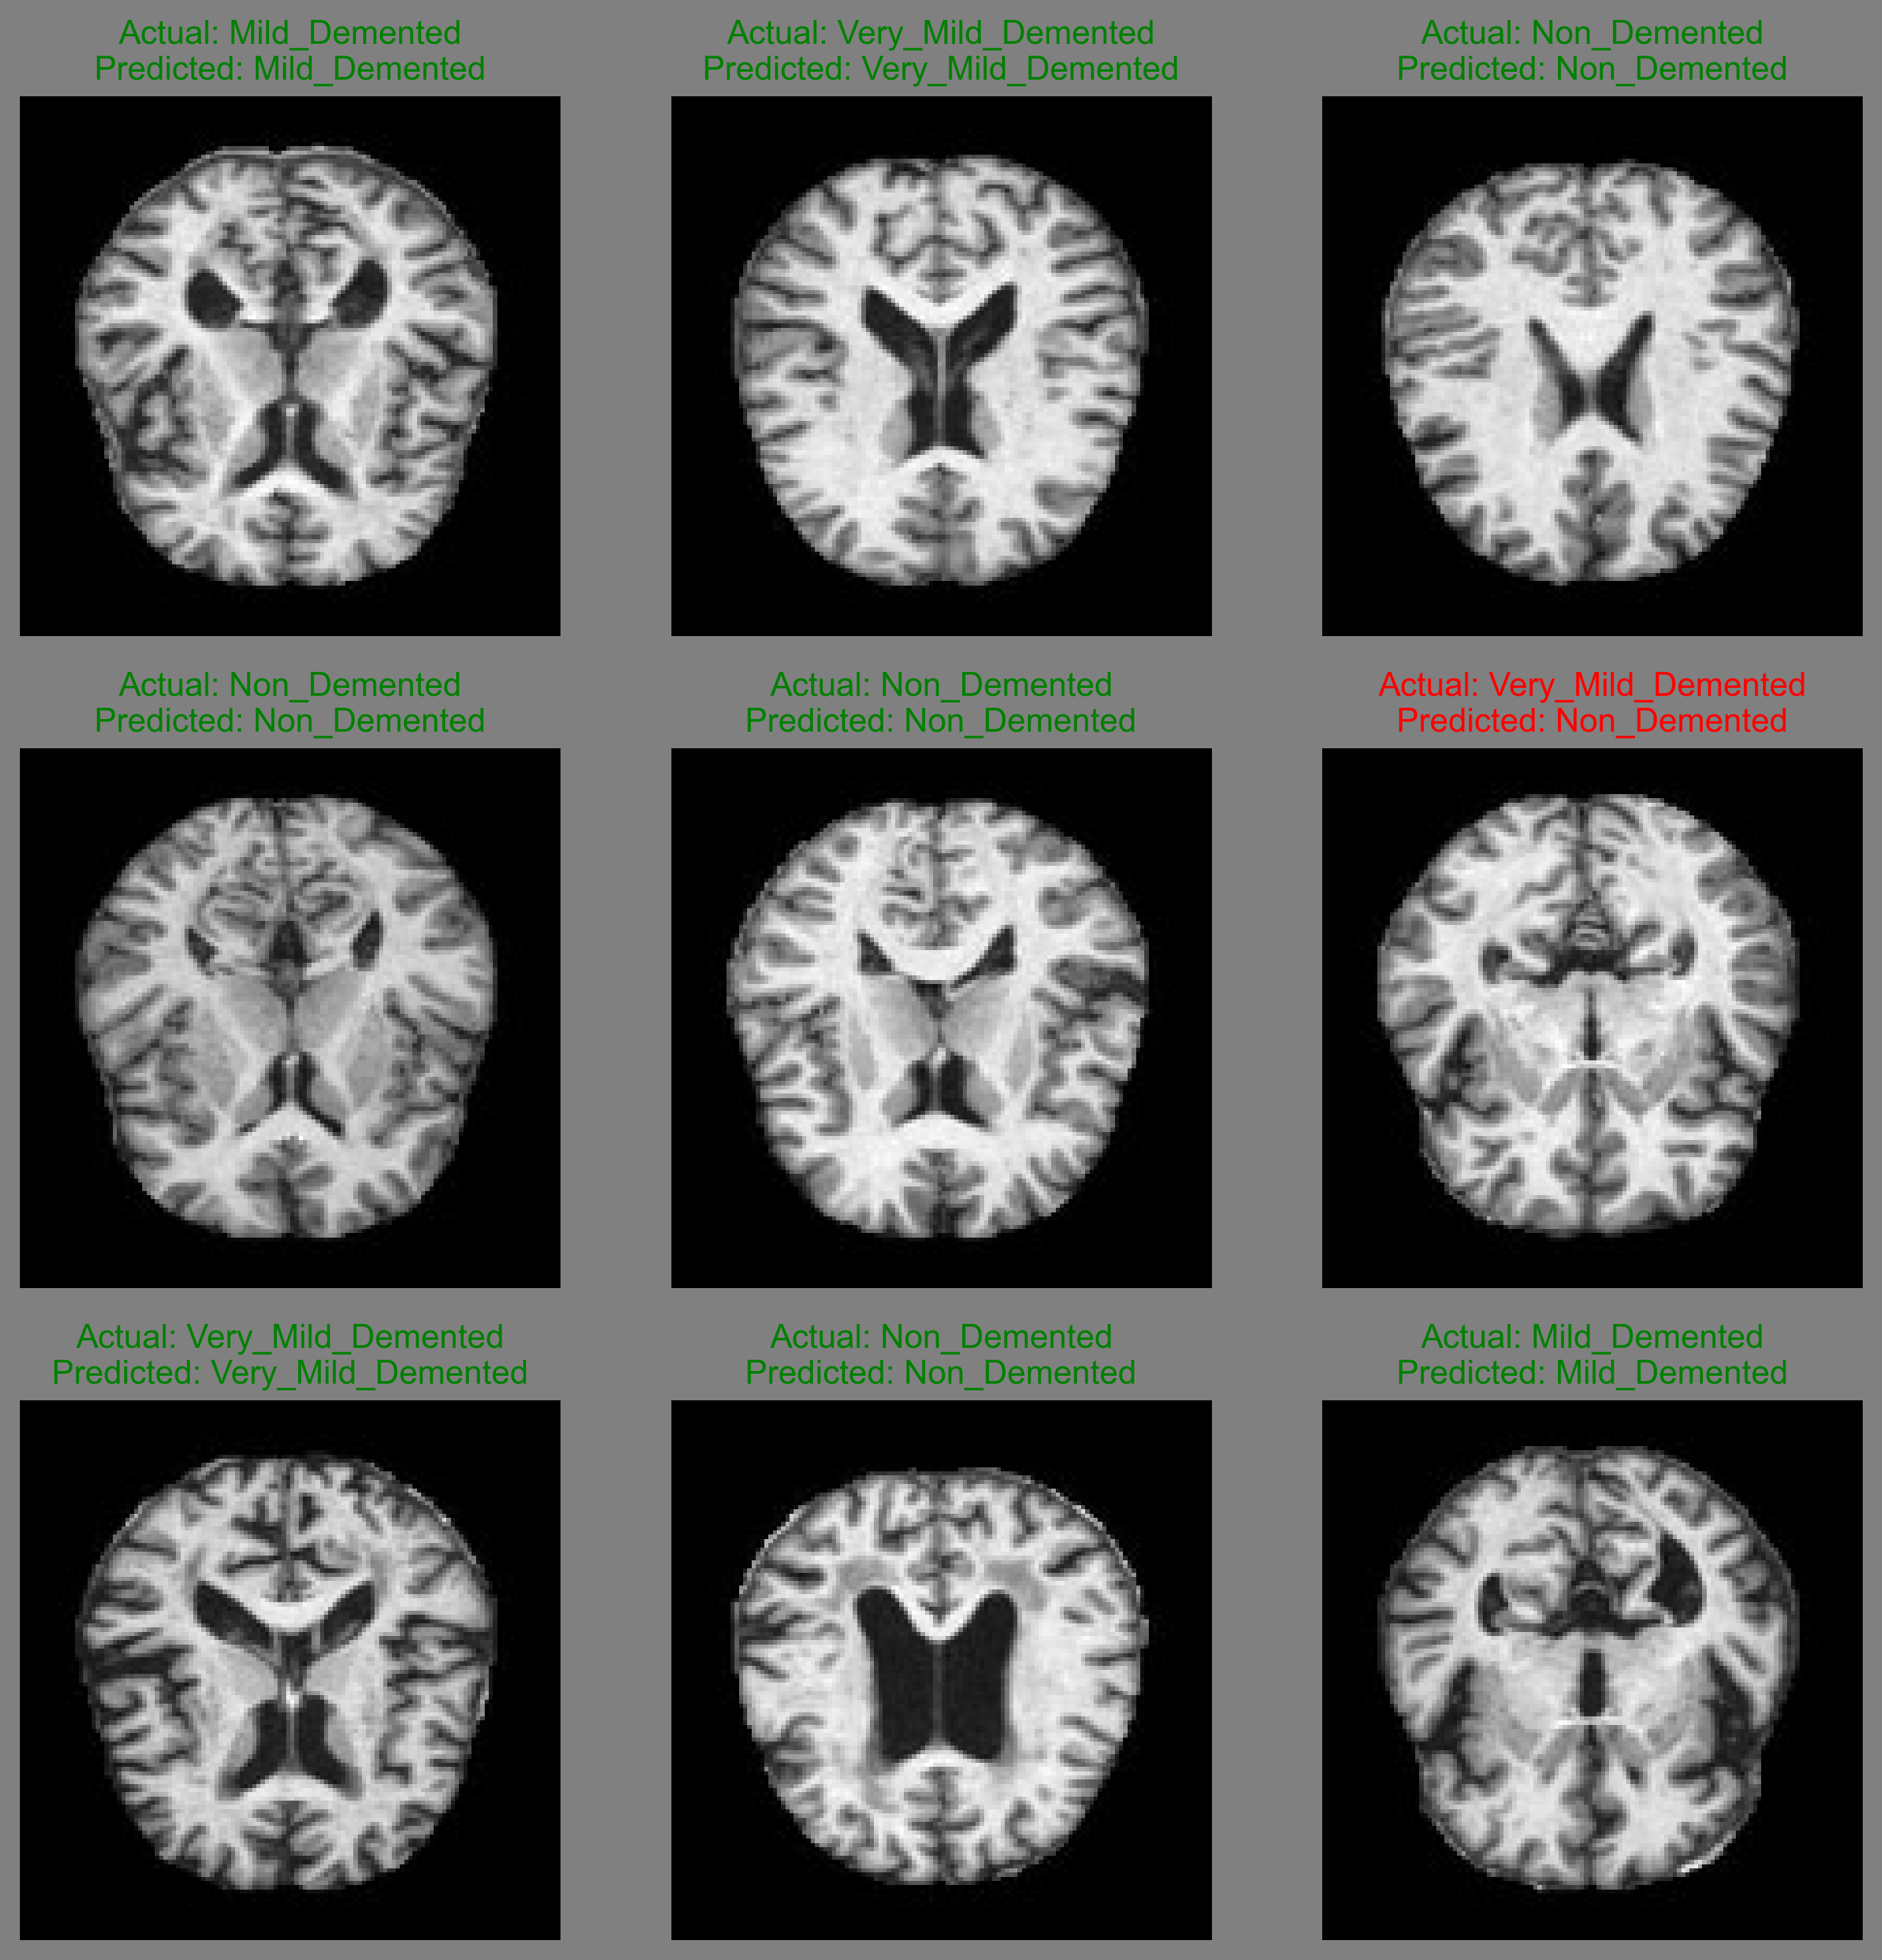

In [28]:
def display_predictions(model, test_data, class_names):
    plt.figure(figsize=(10, 10), facecolor='gray')

    # Taking one batch from the test data
    for images, labels in test_data.take(1):
        # Get predictions for the entire batch
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Display the first 9 images from the batch
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            actual = class_names[labels[i]]
            predicted = class_names[predicted_classes[i]]
            color = "green" if actual == predicted else "red"
            plt.title(f'Actual: {actual}\nPredicted: {predicted}', color=color)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()
display_predictions(model_1, test_data, class_names)
